# Project: Medical Treatment

## Problem Statement

A lot has been said during the past several years about how precision medicine and, more concretely, how genetic testing is going to disrupt the way diseases like cancer are treated.

But this is only partially happening due to the huge amount of manual work still required. Once sequenced, a cancer tumor can have thousands of genetic mutations. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers).

Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature.

We need to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.

This problem was a competition posted on Kaggle with a award of $15,000. This was launched by Memorial Sloan Kettering Cancer Center (MSKCC), accepted by NIPS 2017 Competition Track, because we need your help to take personalized medicine to its full potential.

You can check all details about the competition from following link: https://www.kaggle.com/c/msk-redefining-cancer-treatment

In order to get the dataset please create a login account to Kaggle and go to this problem statement page(given above) and download 2 dataset
<b>training_variants.zip</b> and <b>training_text.zip</b>

## Analysis of Problem Statement

Let's gain an understanding of the provided dataset so that we can better understand the problem in a machine learning context.

In [4]:
# Data Manipulation
import numpy as np
import pandas as pd
from scipy.sparse import hstack

# Data Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Machine Learning
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix
from sklearn.metrics._classification import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE
from mlxtend.classifier import StackingClassifier

# NLP
from nltk.corpus import stopwords

# Other libraries
import re
import time
import math

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from collections import Counter, defaultdict

Loading in the training files

In [7]:
data_variants = pd.read_csv("training/training_variants")
data_text = pd.read_csv("training/training_text", sep = "\|\|", engine= "python",
                        names= ["ID","TEXT"], skiprows = 1)

In [8]:
data_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


Let's understand the data. There are 4 fields above:
1. <b>ID: </b> row id used to link the mutation to the clinical evidence
2. <b>Gene: </b> the gene where this genetic mutation is located
3. <b>Variation: </b> the aminoacid change for this mutation
4. <b>Class: </b> class value 1-9, genetic mutation has been classified as

In [11]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In the dataset above we have two columns: ID and Text. Observe that the ID column is present in both the variants and the text data. Let's continue analyzing the data.

## Data Analysis

### Training Variants

In [12]:
data_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [13]:
data_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [14]:
data_variants.shape

(3321, 4)

### Training Text

In [15]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      3321 non-null   int64 
 1   TEXT    3316 non-null   object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


In [16]:
data_text.describe()

,ID
count,3321.000000
mean,1660.000000
std,958.834449
min,0.000000
25%,830.000000
50%,1660.000000
75%,2490.000000
max,3320.000000


In [17]:
data_text.shape

(3321, 2)

A basic outline of our datasets:
- data_variants: [ID, Gene, Variations, Class]
- data_text: [ID, Text]

Now that we have a better understanding of our dataset, let's try to think of the problem in a Machine Learning context. Our goal is to predict the class of cancer, so we should consider what kind of data is actually present in the class column.

In [18]:
data_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

The data we are working has multiple discrete outputs. Therefore, we can frame this as a multi-class classification problem.

<b>Important Note:</b> This is a medical related problem so correct results are very important. Error can be really costly here so we would like to have results for each class in terms of probability. Time taken by the ML algorithm isn't a huge factor to worry about as long as it is reasonable.

We also want our model to be highly interpretable because a medical practitioner would also want to be provided solid reasoning on why a specific class has been predicted.

Our model will be evaluated using a confusion matrix and multi class log-loss

## Data Preprocessing

In [19]:
import nltk
nltk.download("stopwords")

# Remove all stop words like a, is, an, the, etc.
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lvcie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def data_text_preprocess(total_text, index, column):
    # Remove int values from text data as that might not be important
    if type(total_text) is not int:
        string = ""
        
        # replace special characters with spaces
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', str(total_text))
        
        # replace multiple spaces with single space
        total_text = re.sub('\s+', ' ', str(total_text))
        
        # make everything lower-case scale
        total_text = total_text.lower()
        
        for word in total_text.split():
            # if not a stop word then retain word from text
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [21]:
for index, row in data_text.iterrows():
    if type(row["TEXT"]) is str:
        data_text_preprocess(row["TEXT"], index, "TEXT")

## Missing Data Removal

In [22]:
# Our variation and text data shared the ID column, so let's merge them on ID
result = pd.merge(data_variants, data_text, on = "ID", how= "left")
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [23]:
# Checking for missing values
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


There are some missing rows in our dataset so we should consider how to handle the missing data. A good option might be to try value imputation, but we need to figure out what we should be imputing first.

In [31]:
# Let's merge the gene and variation column to carry out imputation
result.loc[result["TEXT"].isnull(), "TEXT"] = result["Gene"] +' '+ result["Variation"]

In [32]:
result[result.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT


## Create Training, Test, and Validation Data

Before we split the data into training, test, and validation dataset. We want to ensure that all spaces in Gene and Variation column to be replaced by underscores.

In [33]:
y_true = result["Class"].values
result.Gene = result.Gene.str.replace("\s+", "_")
result.Variation = result.Variation.str.replace("\s+", "_")

In [34]:
# Split the data into train and test set 
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# Split the train data now into train validation and cross validation
train_df, val_df, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [35]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', val_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


In [36]:
train_class_distribution = train_df["Class"].value_counts().sort_index()
test_class_distribution = test_df["Class"].value_counts().sort_index()
val_class_distribution = val_df["Class"].value_counts().sort_index()

In [37]:
train_class_distribution

1    363
2    289
3     57
4    439
5    155
6    176
7    609
8     12
9     24
Name: Class, dtype: int64

This tells us that we have a count of 363 for class 1, 289 for class 2, etc. Let's visualize this data in graph format.

## Data Visualization

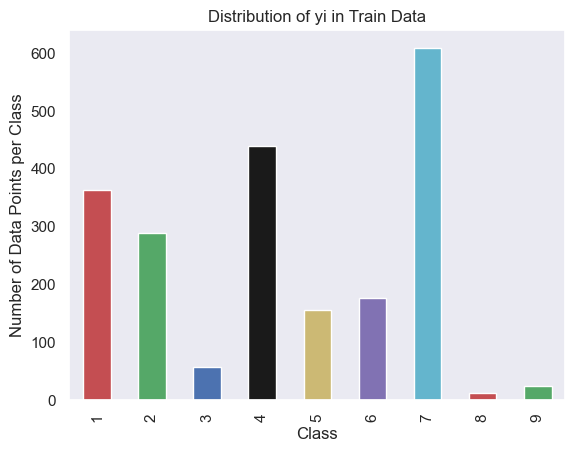

In [39]:
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Number of Data Points per Class')
plt.title('Distribution of yi in Train Data')
plt.grid()
plt.show()

In [40]:
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 609 ( 28.672 %)
Number of data points in class 4 : 439 ( 20.669 %)
Number of data points in class 1 : 363 ( 17.09 %)
Number of data points in class 2 : 289 ( 13.606 %)
Number of data points in class 6 : 176 ( 8.286 %)
Number of data points in class 5 : 155 ( 7.298 %)
Number of data points in class 3 : 57 ( 2.684 %)
Number of data points in class 9 : 24 ( 1.13 %)
Number of data points in class 8 : 12 ( 0.565 %)


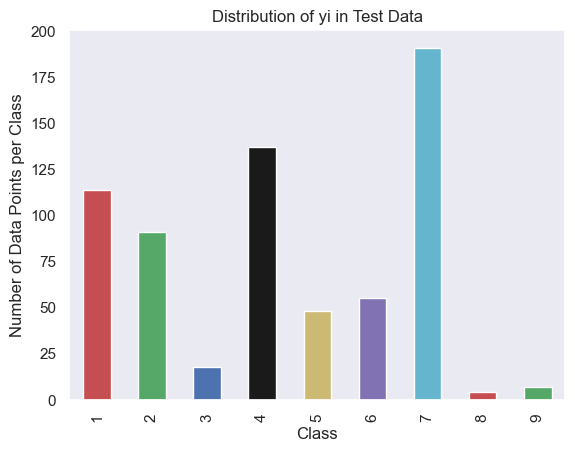

In [41]:
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
test_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Number of Data Points per Class')
plt.title('Distribution of yi in Test Data')
plt.grid()
plt.show()

In [42]:
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 191 ( 28.722 %)
Number of data points in class 4 : 137 ( 20.602 %)
Number of data points in class 1 : 114 ( 17.143 %)
Number of data points in class 2 : 91 ( 13.684 %)
Number of data points in class 6 : 55 ( 8.271 %)
Number of data points in class 5 : 48 ( 7.218 %)
Number of data points in class 3 : 18 ( 2.707 %)
Number of data points in class 9 : 7 ( 1.053 %)
Number of data points in class 8 : 4 ( 0.602 %)


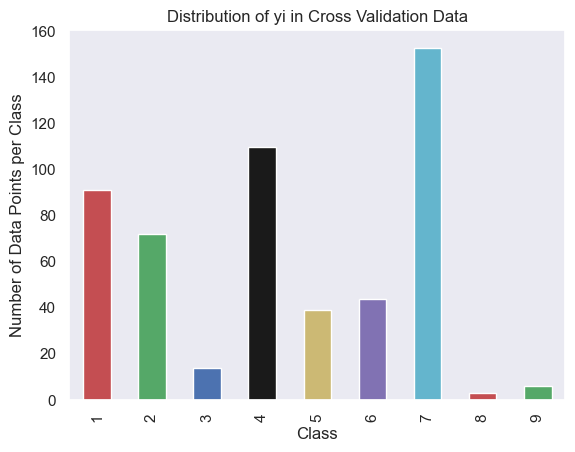

In [44]:
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
val_class_distribution.plot(kind='bar', color=my_colors)
plt.xlabel('Class')
plt.ylabel('Number of Data Points per Class')
plt.title('Distribution of yi in Cross Validation Data')
plt.grid()
plt.show()

In [45]:
sorted_yi = np.argsort(-val_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',val_class_distribution.values[i], '(', np.round((val_class_distribution.values[i]/val_df.shape[0]*100), 3), '%)')

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)


We know we'll need log-loss as a final evaluation metric, now the question is how do we say that the model we are going to build will be a good model? To answer this we'll first build a random model and evaluate log-loss. Our model should return a lower log-loss value than the random model.

## Building a Random Model

We will generate 9 random numbers because we have 9 classes, and we will normalize them such that their sum is equal to 1

In [48]:
test_data_len = test_df.shape[0]
val_data_len = val_df.shape[0]

In [49]:
# we create a output array that has exactly same size as the CV data
val_predicted_y = np.zeros((val_data_len, 9))
for i in range(val_data_len):
    rand_probs = np.random.rand(1,9)
    val_predicted_y[i] = ((rand_probs / sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model", log_loss(y_val, val_predicted_y, eps= 1e-15))

Log loss on Cross Validation Data using Random Model 2.470744368370081


In [51]:
# Test Error
# We create a output array that has same shape as test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

Log loss on Test Data using Random Model 2.486547212662218


In [52]:
# Get index corresponding to max probability
predicted_y = np.argmax(test_predicted_y, axis=1)

In [53]:
# Check result
predicted_y

array([7, 6, 5, 5, 1, 8, 0, 2, 2, 1, 7, 0, 6, 6, 5, 1, 1, 3, 7, 0, 5, 0,
       1, 2, 3, 3, 3, 7, 2, 5, 0, 7, 5, 6, 3, 3, 2, 2, 8, 6, 0, 5, 2, 8,
       2, 2, 2, 7, 1, 1, 7, 6, 1, 2, 7, 5, 6, 1, 6, 7, 6, 0, 7, 2, 6, 5,
       4, 6, 6, 3, 8, 3, 7, 7, 6, 2, 1, 4, 0, 3, 0, 6, 1, 4, 1, 7, 8, 0,
       0, 2, 0, 0, 0, 2, 2, 1, 8, 2, 6, 2, 4, 3, 6, 0, 5, 0, 7, 0, 0, 7,
       6, 2, 1, 2, 5, 4, 0, 8, 0, 0, 2, 4, 4, 1, 4, 8, 5, 0, 8, 0, 4, 6,
       0, 6, 1, 8, 5, 4, 0, 1, 2, 2, 4, 1, 2, 3, 6, 7, 5, 8, 1, 1, 4, 1,
       6, 7, 1, 4, 3, 5, 1, 2, 1, 7, 7, 6, 3, 6, 4, 8, 2, 2, 6, 8, 5, 7,
       8, 2, 8, 1, 8, 0, 8, 8, 5, 1, 6, 6, 3, 2, 0, 8, 8, 7, 7, 3, 1, 7,
       8, 0, 7, 3, 7, 2, 0, 1, 8, 7, 1, 1, 5, 1, 1, 5, 7, 6, 0, 4, 5, 7,
       6, 6, 0, 6, 2, 4, 7, 4, 2, 5, 4, 0, 0, 2, 6, 5, 0, 2, 2, 1, 8, 5,
       8, 0, 1, 8, 0, 6, 5, 6, 5, 3, 6, 5, 3, 3, 6, 8, 7, 3, 7, 7, 2, 0,
       5, 4, 2, 6, 1, 2, 5, 7, 1, 6, 6, 7, 0, 2, 2, 0, 6, 5, 7, 6, 2, 8,
       7, 2, 8, 3, 4, 0, 2, 7, 4, 3, 3, 5, 1, 3, 5,

Python is 0-indexed so the values range from 0-8, we'll adjust this to match our expected values of 1-9

In [54]:
predicted_y = predicted_y + 1
predicted_y

array([8, 7, 6, 6, 2, 9, 1, 3, 3, 2, 8, 1, 7, 7, 6, 2, 2, 4, 8, 1, 6, 1,
       2, 3, 4, 4, 4, 8, 3, 6, 1, 8, 6, 7, 4, 4, 3, 3, 9, 7, 1, 6, 3, 9,
       3, 3, 3, 8, 2, 2, 8, 7, 2, 3, 8, 6, 7, 2, 7, 8, 7, 1, 8, 3, 7, 6,
       5, 7, 7, 4, 9, 4, 8, 8, 7, 3, 2, 5, 1, 4, 1, 7, 2, 5, 2, 8, 9, 1,
       1, 3, 1, 1, 1, 3, 3, 2, 9, 3, 7, 3, 5, 4, 7, 1, 6, 1, 8, 1, 1, 8,
       7, 3, 2, 3, 6, 5, 1, 9, 1, 1, 3, 5, 5, 2, 5, 9, 6, 1, 9, 1, 5, 7,
       1, 7, 2, 9, 6, 5, 1, 2, 3, 3, 5, 2, 3, 4, 7, 8, 6, 9, 2, 2, 5, 2,
       7, 8, 2, 5, 4, 6, 2, 3, 2, 8, 8, 7, 4, 7, 5, 9, 3, 3, 7, 9, 6, 8,
       9, 3, 9, 2, 9, 1, 9, 9, 6, 2, 7, 7, 4, 3, 1, 9, 9, 8, 8, 4, 2, 8,
       9, 1, 8, 4, 8, 3, 1, 2, 9, 8, 2, 2, 6, 2, 2, 6, 8, 7, 1, 5, 6, 8,
       7, 7, 1, 7, 3, 5, 8, 5, 3, 6, 5, 1, 1, 3, 7, 6, 1, 3, 3, 2, 9, 6,
       9, 1, 2, 9, 1, 7, 6, 7, 6, 4, 7, 6, 4, 4, 7, 9, 8, 4, 8, 8, 3, 1,
       6, 5, 3, 7, 2, 3, 6, 8, 2, 7, 7, 8, 1, 3, 3, 1, 7, 6, 8, 7, 3, 9,
       8, 3, 9, 4, 5, 1, 3, 8, 5, 4, 4, 6, 2, 4, 6,

Confusion, Precision, and Recall Matrices

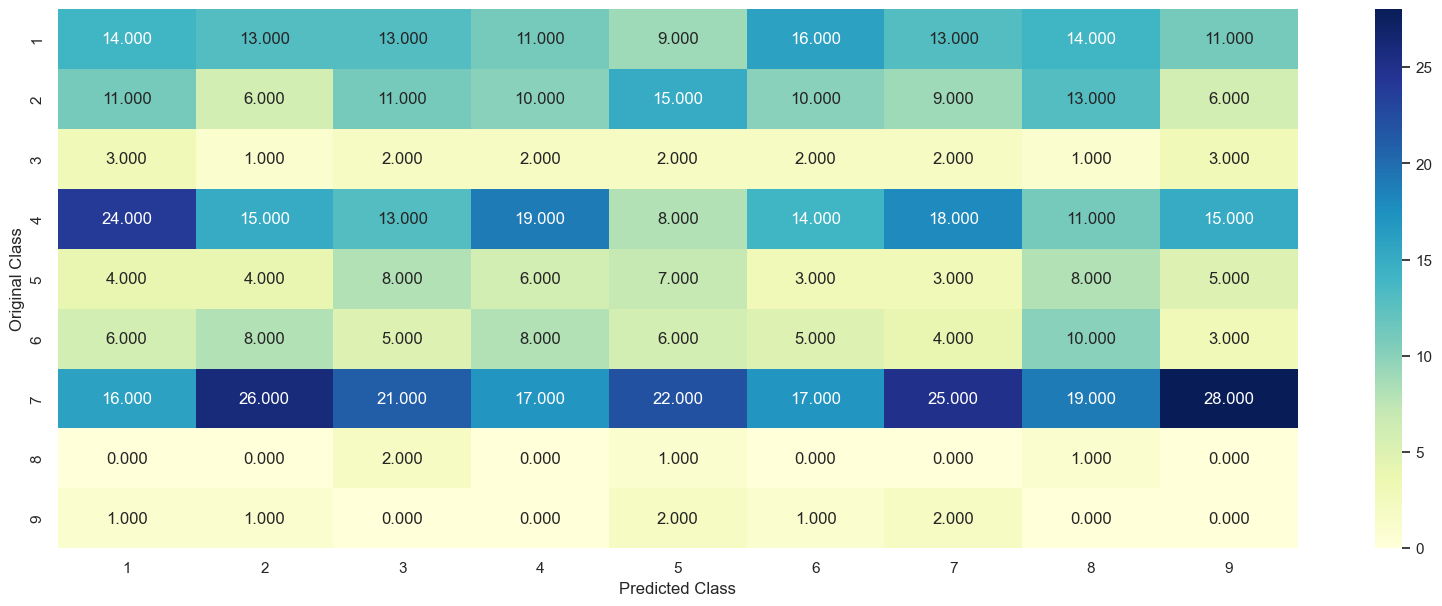

In [55]:
# Confusion Matrix
C = confusion_matrix(y_test, predicted_y)

labels = [1,2,3,4,5,6,7,8,9]
plt.figure(figsize=(20,7))
sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

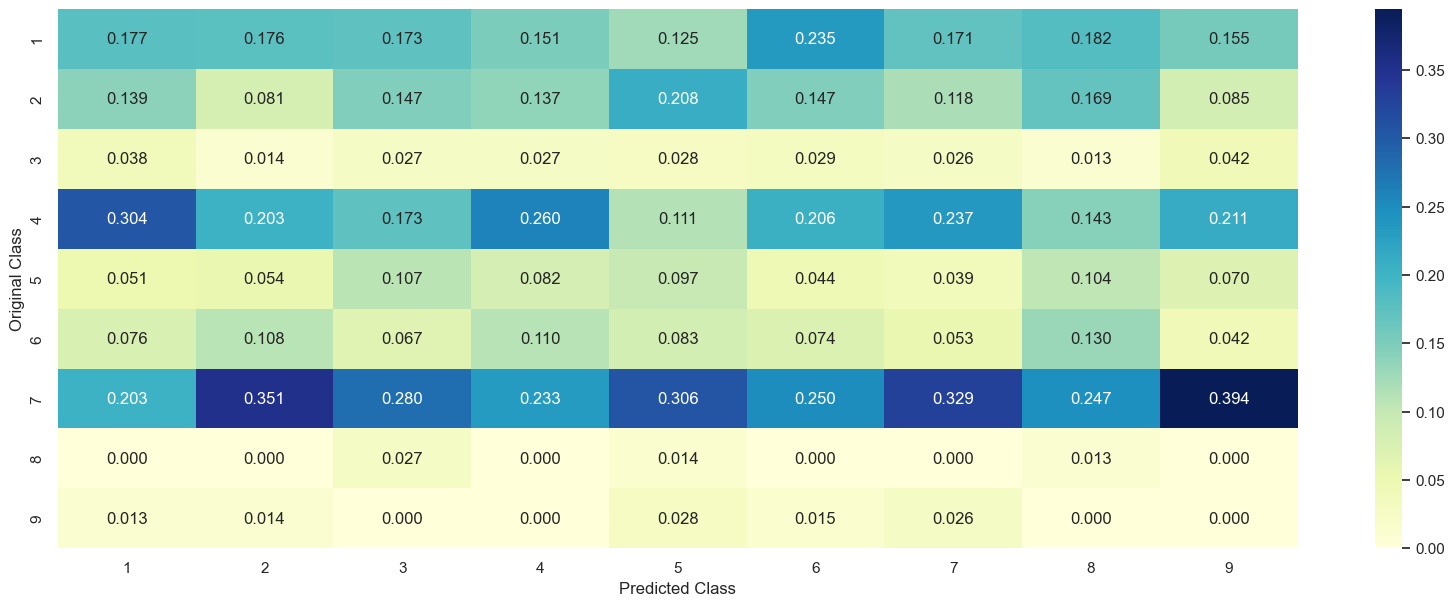

In [56]:
# Precision Matrix
B =(C/C.sum(axis=0))

plt.figure(figsize=(20,7))
sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

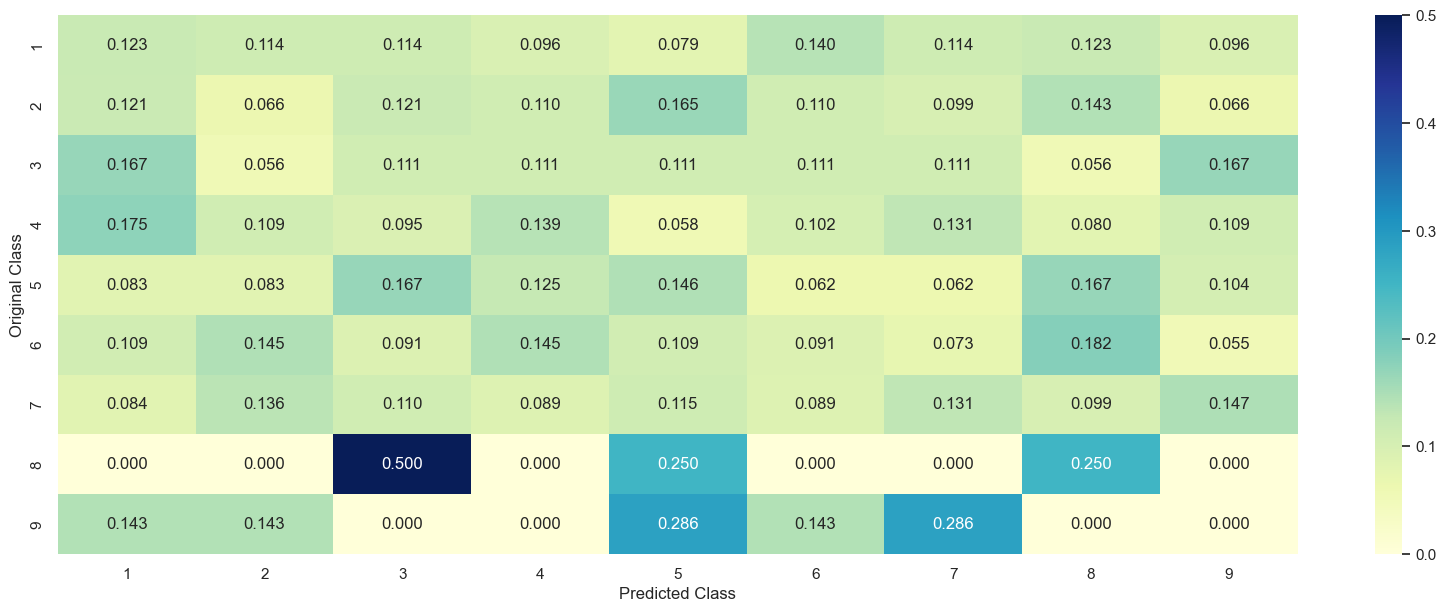

In [57]:
# Recall Matrix
A =(((C.T)/(C.sum(axis=1))).T)

plt.figure(figsize=(20,7))
sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

## One-hot Encoding

We'll go through each independent column to ensure it's useful in determining our target variable. We'll start off by exploring the Gene column which is categorical in nature.

In [58]:
unique_genes = train_df["Gene"].value_counts()
print("Number of Unique Genes : {}".format(unique_genes.shape[0]))
unique_genes.head(10)

Number of Unique Genes : 236


BRCA1     160
TP53      111
EGFR       91
PTEN       82
BRCA2      81
KIT        65
BRAF       60
ERBB2      49
ALK        48
PDGFRA     37
Name: Gene, dtype: int64

In [59]:
# Let's check the number of unique values present in gene
unique_genes.shape[0]

236

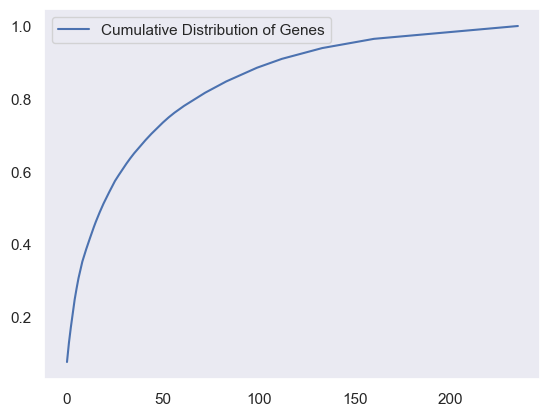

In [60]:
# Display cumulative distribution of Gene's unique values

s = sum(unique_genes.values)
h = unique_genes.values / s
c = np.cumsum(h)

plt.plot(c, label = "Cumulative Distribution of Genes")
plt.grid()
plt.legend()
plt.show()

We will convert these categorical values to a format that will be easier for an ML algorithm to take as input. We'll use the following two techniques to carry this out:
1. <b>One-hot encoding</b>
2. <b> Response Encoding</b> (Mean Imputation)

In [62]:
# One-hot encoding of Gene feature
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df["Gene"])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df["Gene"])
val_gene_feature_onehotCoding = gene_vectorizer.transform(val_df["Gene"])

In [63]:
# Let's check the number of generated columns after one-hot encoding
train_gene_feature_onehotCoding.shape

(2124, 236)

In [65]:
# column names following one-hot encoding
gene_vectorizer.vocabulary_

{'mlh1': 133,
 'ctnnb1': 54,
 'egfr': 60,
 'kit': 114,
 'erbb2': 66,
 'tsc1': 226,
 'tsc2': 227,
 'atr': 14,
 'bcl2': 22,
 'fgfr2': 87,
 'brca1': 26,
 'runx1': 196,
 'b2m': 18,
 'eif1ax': 61,
 'dicer1': 56,
 'smo': 209,
 'braf': 25,
 'ppp2r1a': 170,
 'map2k1': 122,
 'stat3': 215,
 'raf1': 185,
 'alk': 6,
 'ar': 8,
 'flt3': 91,
 'chek2': 49,
 'msh2': 135,
 'notch1': 147,
 'ago2': 2,
 'kras': 119,
 'fbxw7': 83,
 'spop': 212,
 'mpl': 134,
 'smad4': 206,
 'pik3r1': 164,
 'tp53': 224,
 'cdkn2a': 45,
 'nfe2l2': 144,
 'vhl': 230,
 'bcor': 24,
 'etv6': 76,
 'brca2': 27,
 'ntrk1': 152,
 'tet2': 220,
 'hras': 102,
 'esr1': 74,
 'smad3': 205,
 'ptch1': 173,
 'rac1': 179,
 'cbl': 34,
 'acvr1': 1,
 'pdgfra': 159,
 'ret': 190,
 'smad2': 204,
 'jak1': 108,
 'carm1': 32,
 'akt1': 3,
 'pik3ca': 161,
 'kdm5c': 111,
 'akt3': 5,
 'keap1': 113,
 'epas1': 64,
 'ros1': 195,
 'ezh2': 78,
 'pms2': 168,
 'smarca4': 207,
 'ercc2': 69,
 'mtor': 137,
 'xrcc2': 234,
 'msh6': 136,
 'ewsr1': 77,
 'ccnd1': 35,
 'pik3r

## Response Encoding

In [66]:
"""
Summary: Code for response coding with Laplace smoothing
Args:
    alpha ([integer]): used for Laplace smoothing
    feature ([list]): ["Gene", "Variation"]
    df ([dataframe]): ["traind_df", "test_df", "val_df"]

Algorithm

Consider all unique values and the number of occurances of given feature in train data dataframe build a vector  (1*19), the first element = (number of times its occurred in class1 + 10*alpha / number of time it occurred in total data + 90*alpha)

gv_dict is like a look up table for every gene its store a (1*9) representation of it for a value of feature in df:
    if it is in train data:
        we add the vector that was stored in "gv_dict" look up table to "gv_fea"
    if it is not there in train data:
        we add [1/9, 1/9, 1/9, 1/9,1/9, 1/9, 1/9, 1/9, 1/9] to 'gv_fea'
return "gv_fea"
"""

# get_gv_fea_dict = Get Gene Variation Feature Dict

def get_gv_fea_dict(alpha, feature, df):
    """
    Args:
        value_count: it contains a dict like
    
        print(train_df['Gene'].value_counts())
        output:
            {
                BRCA1     173
                TP53      114
                EGFR       86
                PTEN       80
                BRCA2      72
                        ... 
                LATS1       1
                SDHB        1
                CDKN2B      1
                ARAF        1
                AXL         1
            }
        print(train_df['Variation'].value_counts())
        output:
            {
                Truncating_Mutations    60
                Deletion                47
                Amplification           42
                Fusions                 25
                G12V                     4
                                        ..
                F384Y                    1
                S1986F                   1
                F1524V                   1
                T19N                     1
                P34R                     1
            }   
    """
    
    value_count = train_df[feature].value_counts()
    
    # gv_dict : Gene Variation Dict, which contains the probability array for each gene / variation
    gv_dict = dict()
    
    # denominator will contain the number of time that particular feature occurred in whole data
    for i, denominator in value_count.items():
        # vec will contain (p(yi == 1 / Gi)) probability of gene, variation belongs to particular class
        
        #vec is 9 dimensional vector
        vec = []
        
        for k in range(1,10):
            """
                print(train_df.loc[(train_df['Class']==1) & (train_df['Gene']=='BRCA1')])
                Output: 
                {
                    ID   Gene             Variation  Class  \
                    2421  2421  BRCA1  Truncating_Mutations      1   
                    2583  2583  BRCA1                E1660G      1   
                    2579  2579  BRCA1                G1763V      1   
                    2510  2510  BRCA1                S1841N      1   
                    2592  2592  BRCA1                V1838E      1   
                    2577  2577  BRCA1                A1752V      1   
                    2619  2619  BRCA1                V1810G      1   
                    2438  2438  BRCA1                W1837C      1   
                    2596  2596  BRCA1                G1788D      1   
                    2586  2586  BRCA1                M1628V      1   
                    2432  2432  BRCA1                L1657P      1   
                }
            """
            
            cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
            
            # cls_cnt.shape[0](numerator) will contain the number of time that particular feature occurred in whole data
            
            vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
            
        # we are adding the gene/variation to the dict as key and vec as value
        gv_dict[i]=vec
    return gv_dict

# Get Gene variation feature
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha, feature, df)
    
    # value_count is similar in get_gv_fea_dict
    value_count = train_df[feature].value_counts()
    
    # gv_fea: Gene_variation feature, it will contain the feature for each value in the data
    gv_fea = []
    
    # for every feature values in the given data frame we will check if it is in the train data then we will add the feature to gv_fea
    # if not we will add [1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9] to gv_fea
    for index,row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [67]:
# response-coding of the Gene feature

# alpha is used for Laplace smoothing
alpha = 1

# train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))

# test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))

# val gene feature
val_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", val_df))

In [68]:
# Check columns after response encoding. Should result in 9 columns for Gene column.
train_gene_feature_responseCoding.shape

(2124, 9)

Now we beg the question, how good is the gene column feature for predicting my 9 classes? One idea could be that we will build the model having only the one-hot encoded gene column with a simple model like logistic regression. If log-loss with only one gene column performs better than the random model, then this feature is important.

In [69]:
# We need a hyperparamaeter for SGD Classifier
alpha = [10 ** x for x in range(-5,1)]

In [70]:
# We will be using the SGD classifier from scikit-learn
# as well as a calibrated classifier to get the result into probability format to be used for log loss
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(val_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.1866232877722056
For values of alpha =  0.0001 The log loss is: 1.1656291004448647
For values of alpha =  0.001 The log loss is: 1.2116540033232346
For values of alpha =  0.01 The log loss is: 1.3235631693858818
For values of alpha =  0.1 The log loss is: 1.4288452346419915
For values of alpha =  1 The log loss is: 1.4772290821435674


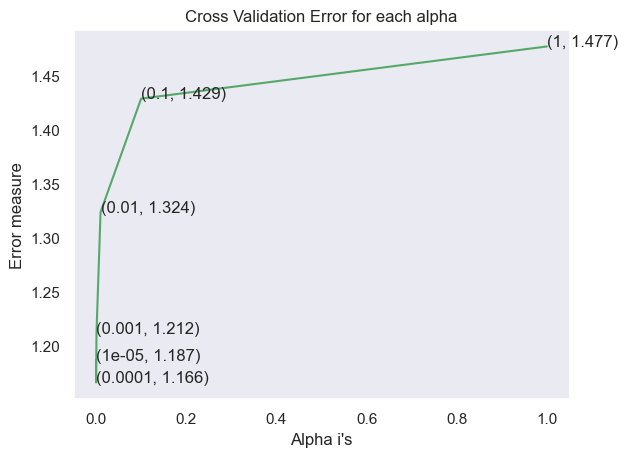

In [71]:
# Visualize to find best alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [72]:
# Use best alpha from graph then compute log loss
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 1.0001994587316319
For values of best alpha =  0.0001 The cross validation log loss is: 1.1656291004448647
For values of best alpha =  0.0001 The test log loss is: 1.1754888902096368


Now let's check how many values are overlapping between train, test or between CV and train

In [73]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
val_coverage=val_df[val_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [74]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',val_coverage, 'out of ',val_df.shape[0],":" ,(val_coverage/val_df.shape[0])*100)

1. In test data 649 out of 665 : 97.59398496240601
2. In cross validation data 515 out of  532 : 96.80451127819549


## Evaluating Variation Column

Variation is also a categorical variable so we have handle it the same way we handled the <b>Gene</b> column. We will again get the one-hot and response encoding variables for the variation column.

In [75]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occurred most
print(unique_variations.head(10))

Number of Unique Variations : 1925
Truncating_Mutations    57
Deletion                53
Amplification           44
Fusions                 23
Overexpression           4
E17K                     3
Q61R                     3
Q61H                     3
F384L                    2
TMPRSS2-ETV1_Fusion      2
Name: Variation, dtype: int64


[0.02683616 0.05178908 0.07250471 ... 0.99905838 0.99952919 1.        ]


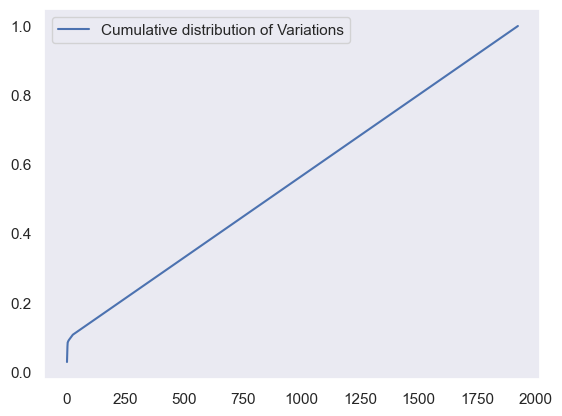

In [76]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

In [77]:
# one-hot encoding of variation feature.
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
val_variation_feature_onehotCoding = variation_vectorizer.transform(val_df['Variation'])

In [78]:
train_variation_feature_onehotCoding.shape

(2124, 1958)

In [79]:
# alpha is used for laplace smoothing
alpha = 1
# train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
# test gene feature
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
# cross validation gene feature
val_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", val_df))

In [80]:
train_variation_feature_responseCoding.shape

(2124, 9)

In [81]:
# We need a hyperparemeter for SGD classifier.
alpha = [10 ** x for x in range(-5, 1)]

In [82]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(val_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.7152890982750935
For values of alpha =  0.0001 The log loss is: 1.711626970468659
For values of alpha =  0.001 The log loss is: 1.7167199703925442
For values of alpha =  0.01 The log loss is: 1.7340947114604115
For values of alpha =  0.1 The log loss is: 1.752079696113601
For values of alpha =  1 The log loss is: 1.7522342563230446


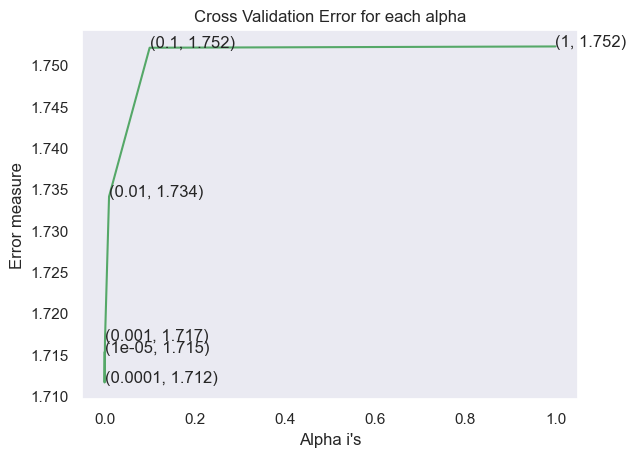

In [83]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [84]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.7041046447142292
For values of best alpha =  0.0001 The cross validation log loss is: 1.711626970468659
For values of best alpha =  0.0001 The test log loss is: 1.7087853692036477


In [85]:
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
val_coverage=val_df[val_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [86]:
print('1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',val_coverage, 'out of ',val_df.shape[0],":" ,(val_coverage/val_df.shape[0])*100)

1. In test data 70 out of 665 : 10.526315789473683
2. In cross validation data 50 out of  532 : 9.398496240601503


In [87]:
# cls_text is a data frame
# for every row in data frame consider the 'TEXT'
# split the words by space
# make a dict with those words
# increment its count whenever we see that word

def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary

In [88]:
def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [90]:
# building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.vocabulary_

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 53813


In [91]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

In [92]:
#response encoding of text features
train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
val_text_feature_responseCoding  = get_text_responsecoding(val_df)

In [93]:
# Normalize row values so they sum to 1  
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
val_text_feature_responseCoding = (val_text_feature_responseCoding.T/val_text_feature_responseCoding.sum(axis=1)).T

In [94]:
# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
val_text_feature_onehotCoding = text_vectorizer.transform(val_df['TEXT'])
# don't forget to normalize every feature
val_text_feature_onehotCoding = normalize(val_text_feature_onehotCoding, axis=0)

In [95]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [96]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5528, 4: 3684, 5: 3034, 6: 2865, 7: 2399, 8: 1982, 9: 1528, 12: 1377, 10: 1245, 13: 1108, 11: 1099, 14: 976, 15: 886, 16: 874, 20: 724, 18: 645, 22: 539, 17: 530, 21: 513, 24: 494, 19: 486, 30: 410, 23: 366, 39: 360, 25: 356, 26: 355, 29: 332, 28: 328, 43: 325, 27: 317, 32: 300, 40: 265, 31: 263, 42: 261, 33: 257, 35: 246, 36: 243, 34: 227, 37: 220, 41: 195, 38: 193, 44: 190, 45: 189, 48: 176, 56: 175, 50: 167, 60: 166, 46: 162, 51: 156, 53: 148, 49: 148, 47: 143, 54: 137, 78: 134, 57: 131, 59: 130, 67: 129, 58: 122, 52: 122, 64: 109, 66: 107, 63: 106, 65: 104, 70: 103, 68: 103, 61: 102, 55: 102, 62: 101, 69: 99, 84: 93, 75: 91, 80: 90, 71: 87, 76: 85, 72: 83, 82: 79, 81: 78, 73: 77, 85: 73, 91: 70, 83: 70, 74: 70, 79: 69, 96: 68, 87: 68, 77: 66, 88: 65, 100: 64, 97: 64, 86: 64, 117: 63, 89: 63, 99: 61, 94: 60, 98: 59, 104: 57, 90: 57, 106: 56, 93: 56, 111: 54, 102: 54, 101: 54, 112: 53, 110: 52, 95: 52, 126: 51, 147: 48, 120: 48, 128: 47, 107: 47, 92: 46, 138: 45, 131: 44,

In [97]:
cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(val_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.2681628052112532
For values of alpha =  0.0001 The log loss is: 1.1064015836498031
For values of alpha =  0.001 The log loss is: 1.1048784954813684
For values of alpha =  0.01 The log loss is: 1.1667102355495897
For values of alpha =  0.1 The log loss is: 1.4201025173632689
For values of alpha =  1 The log loss is: 1.649861062712754


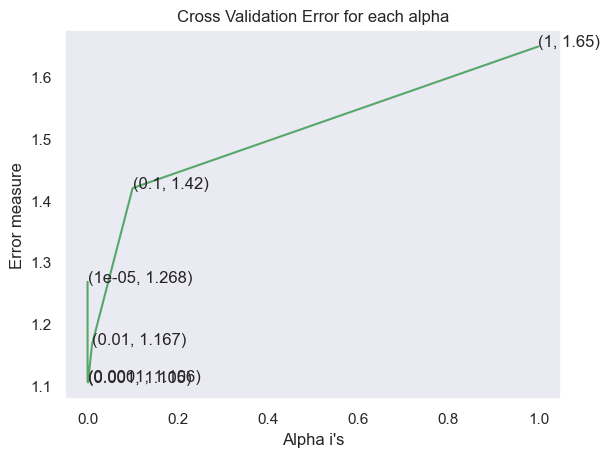

In [98]:
# Lets plot the same to check the best Alpha value
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [99]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.6741845364555253
For values of best alpha =  0.0001 The cross validation log loss is: 1.1064015836498031
For values of best alpha =  0.0001 The test log loss is: 1.2384615924860636


In [102]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.vocabulary_

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [103]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(val_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

97.128 % of word of test data appeared in train data
97.612 % of word of Cross Validation appeared in train data


With this information, we know that all 3 columns are going to be important

## Data Preparation for Machine Learning Models

In [104]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0)) 
    labels = [1,2,3,4,5,6,7,8,9]
    # representing A in heatmap format
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    # representing B in heatmap format
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()


def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [297]:
# this function will be used just for naive bayes
# for the given indices, we will print the name of the features
# and we will check whether the feature present in the test point text or not
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.vocabulary_)
    fea2_len = len(var_count_vec.vocabulary_)
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = list(gene_vec.vocabulary_.keys())[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = list(var_vec.vocabulary_.keys())[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = list(text_vec.vocabulary_.keys())[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

## Combining all 3 Features Together

In [298]:
# merging gene, variance and text features

# building train, test and cross validation data sets
# a = [[1, 2], 
#      [3, 4]]
# b = [[4, 5], 
#      [6, 7]]
# hstack(a, b) = [[1, 2, 4, 5],
#                [ 3, 4, 6, 7]]

train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((val_gene_feature_onehotCoding,val_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

val_x_onehotCoding = hstack((cv_gene_var_onehotCoding, val_text_feature_onehotCoding)).tocsr()
val_y = np.array(list(val_df['Class']))


train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
val_gene_var_responseCoding = np.hstack((val_gene_feature_responseCoding,val_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
val_x_responseCoding = np.hstack((val_gene_var_responseCoding, val_text_feature_responseCoding))

In [299]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", val_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56007)
(number of data points * number of features) in test data =  (665, 56007)
(number of data points * number of features) in cross validation data = (532, 56007)


In [300]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", val_x_responseCoding.shape)

 Response encoding features :
(number of data points * number of features) in train data =  (2124, 27)
(number of data points * number of features) in test data =  (665, 27)
(number of data points * number of features) in cross validation data = (532, 27)


## Naive Bayes

In [301]:
# http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
    cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(val_y, sig_clf_probs)) 

for alpha = 1e-05
Log Loss : 1.2571985669563994
for alpha = 0.0001
Log Loss : 1.2499794146158416
for alpha = 0.001
Log Loss : 1.2394361745598
for alpha = 0.1
Log Loss : 1.221297691558205
for alpha = 1
Log Loss : 1.26814254054625
for alpha = 10
Log Loss : 1.3440239821633817
for alpha = 100
Log Loss : 1.3286654025010312
for alpha = 1000
Log Loss : 1.2679417842697818


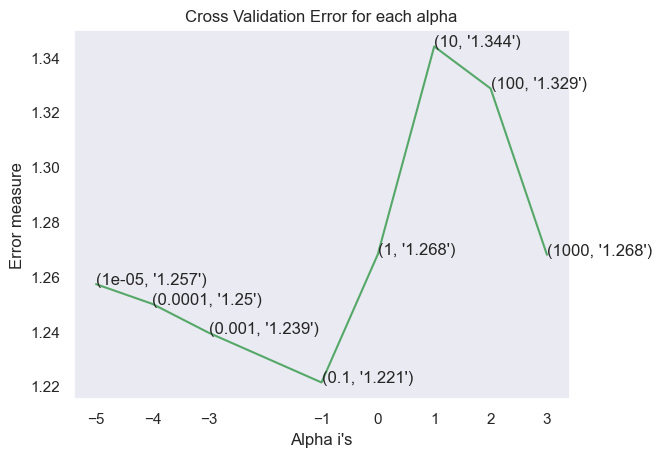

In [302]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [303]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.1 The train log loss is: 0.8666961965006124
For values of best alpha =  0.1 The cross validation log loss is: 1.221297691558205
For values of best alpha =  0.1 The test log loss is: 1.2764203130298726


Testing our Naive Bayes model with the best found value of alpha on the testing set

Log Loss:  1.221297691558205
Number of missclassified point:  0.38721804511278196
-------------------- Confusion matrix --------------------


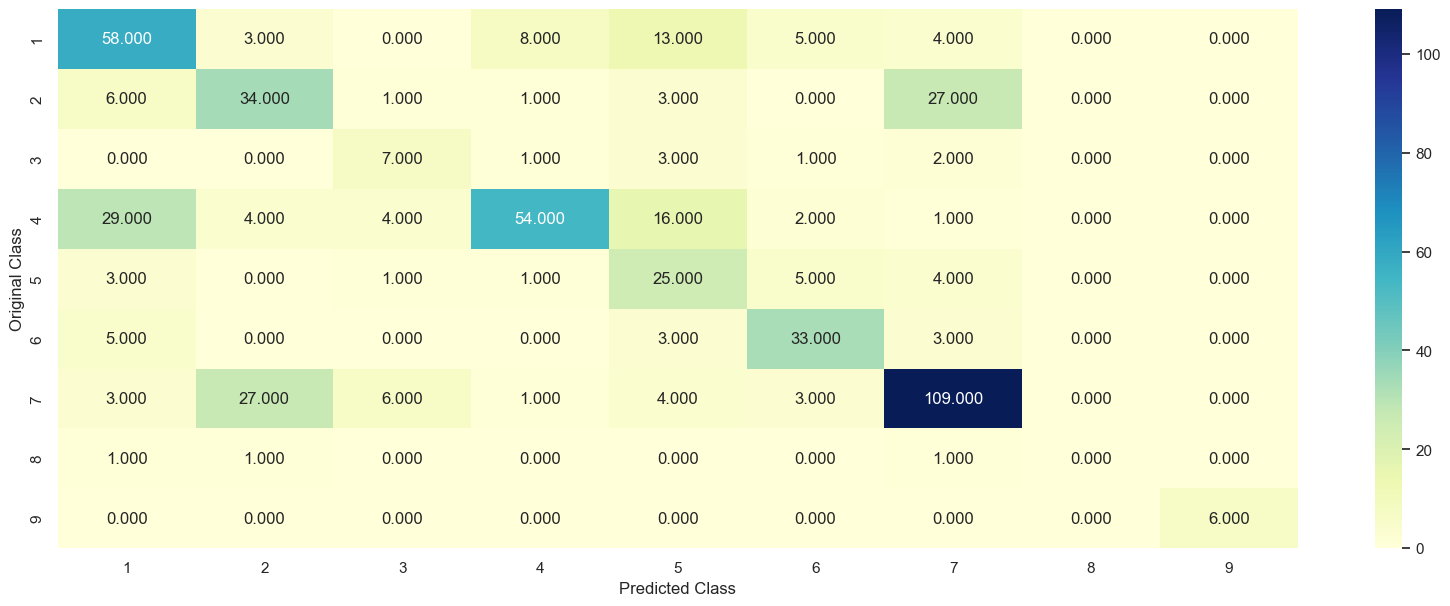

-------------------- Precision matrix (Columm Sum=1) --------------------


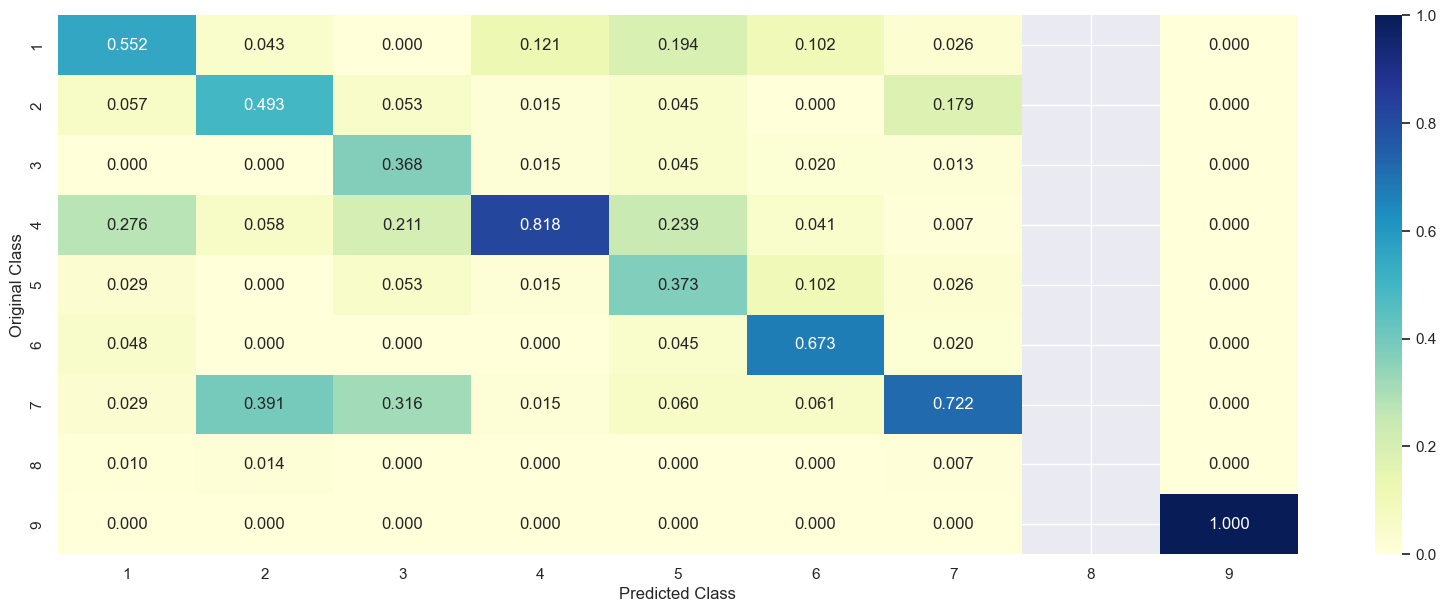

-------------------- Recall matrix (Row sum=1) --------------------


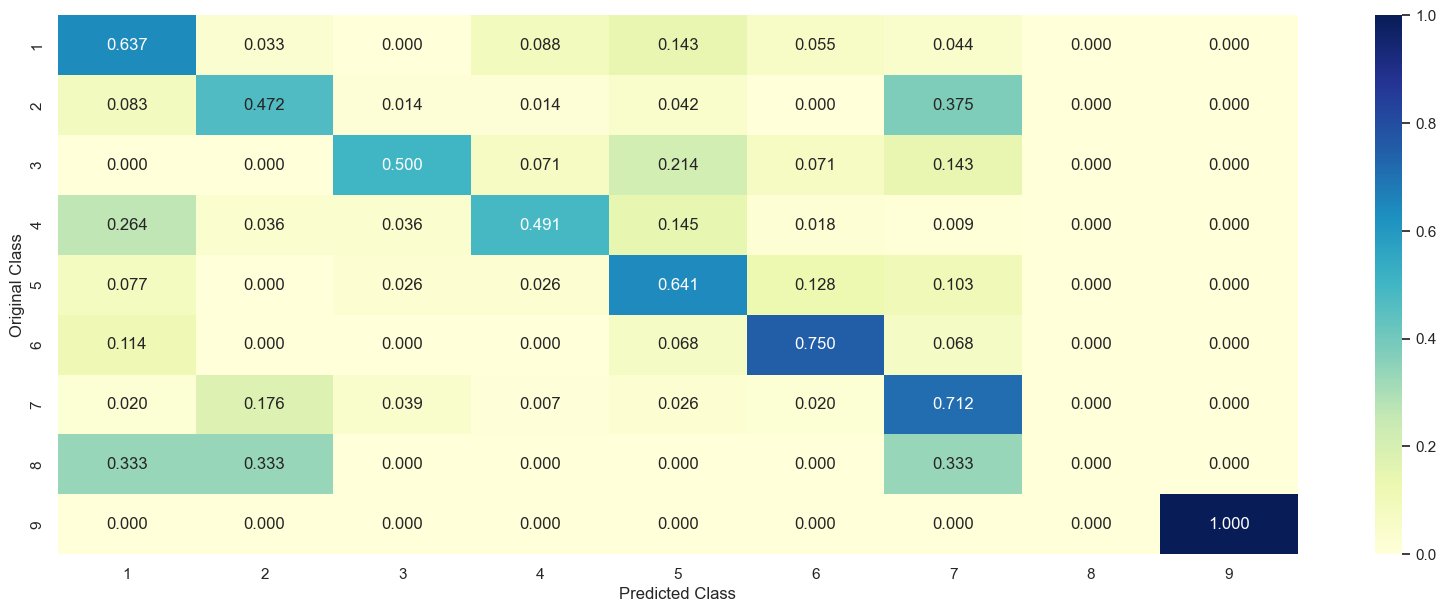

In [304]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
# to avoid rounding error while multiplying probabirlies we use log-probability estimates
print("Log Loss: ", log_loss(val_y, sig_clf_probs))
print("Number of missclassified point: ", np.count_nonzero((sig_clf.predict(val_x_onehotCoding)-val_y))/val_y.shape[0])
plot_confusion_matrix(val_y, sig_clf.predict(val_x_onehotCoding.toarray()))

In [305]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.5645 0.0766 0.0164 0.1152 0.0448 0.0383 0.1347 0.005  0.0046]]
Actual Class : 5
--------------------------------------------------
Out of the top  100  features  0 are present in query point


In [307]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_log_prob_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.125  0.2066 0.0259 0.1784 0.0703 0.0614 0.2103 0.1147 0.0073]]
Actual Class : 7
--------------------------------------------------
76 Text feature [bridge] present in test data point [True]
Out of the top  100  features  1 are present in query point


## K-Nearest Neighbor Classification

In [308]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(val_x_responseCoding)
    cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(val_y, sig_clf_probs))

for alpha = 5
Log Loss : 1.1088423627865092
for alpha = 11
Log Loss : 1.0844977841921033
for alpha = 15
Log Loss : 1.0658850241382005
for alpha = 21
Log Loss : 1.0602925575410103
for alpha = 31
Log Loss : 1.078753267634539
for alpha = 41
Log Loss : 1.0763638634203792
for alpha = 51
Log Loss : 1.0859282324273887
for alpha = 99
Log Loss : 1.11679645496188


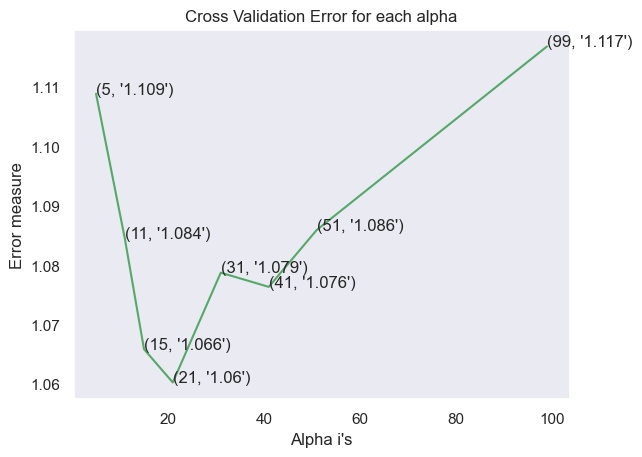

In [309]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [310]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  21 The train log loss is: 0.7417869177709081
For values of best alpha =  21 The cross validation log loss is: 1.0602925575410103
For values of best alpha =  21 The test log loss is: 1.0661067619408104


Log loss : 1.0602925575410103
Number of mis-classified points : 0.3684210526315789
-------------------- Confusion matrix --------------------


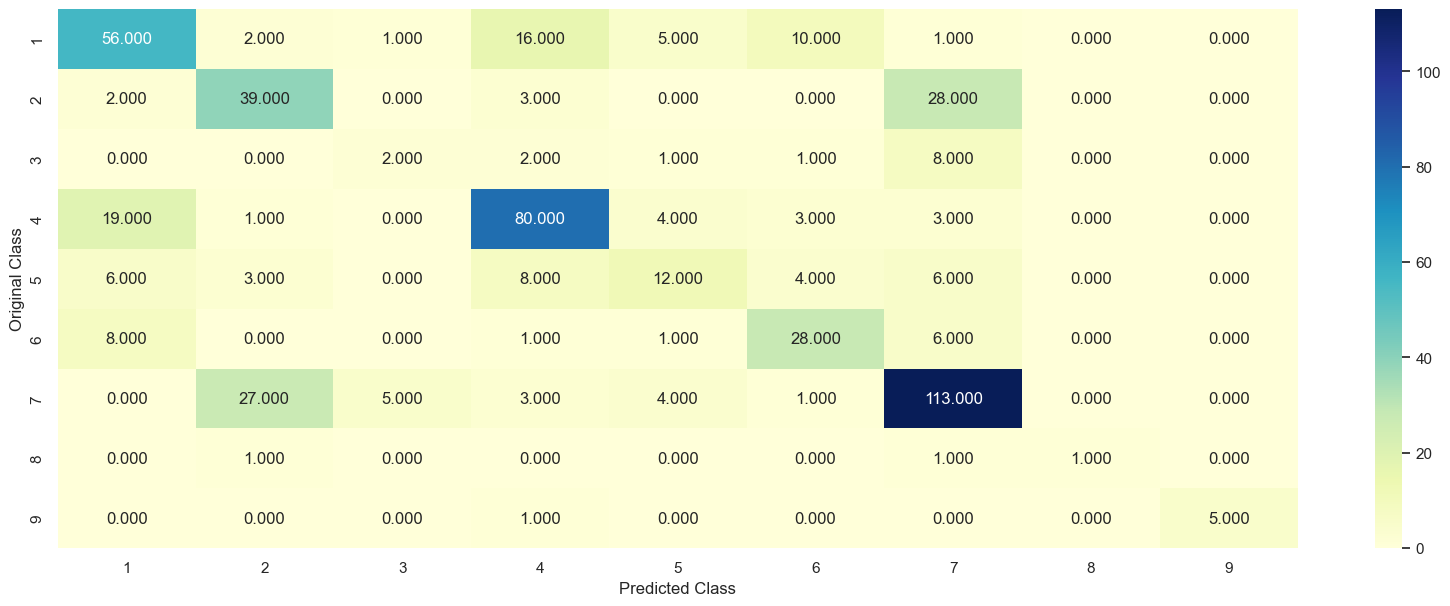

-------------------- Precision matrix (Columm Sum=1) --------------------


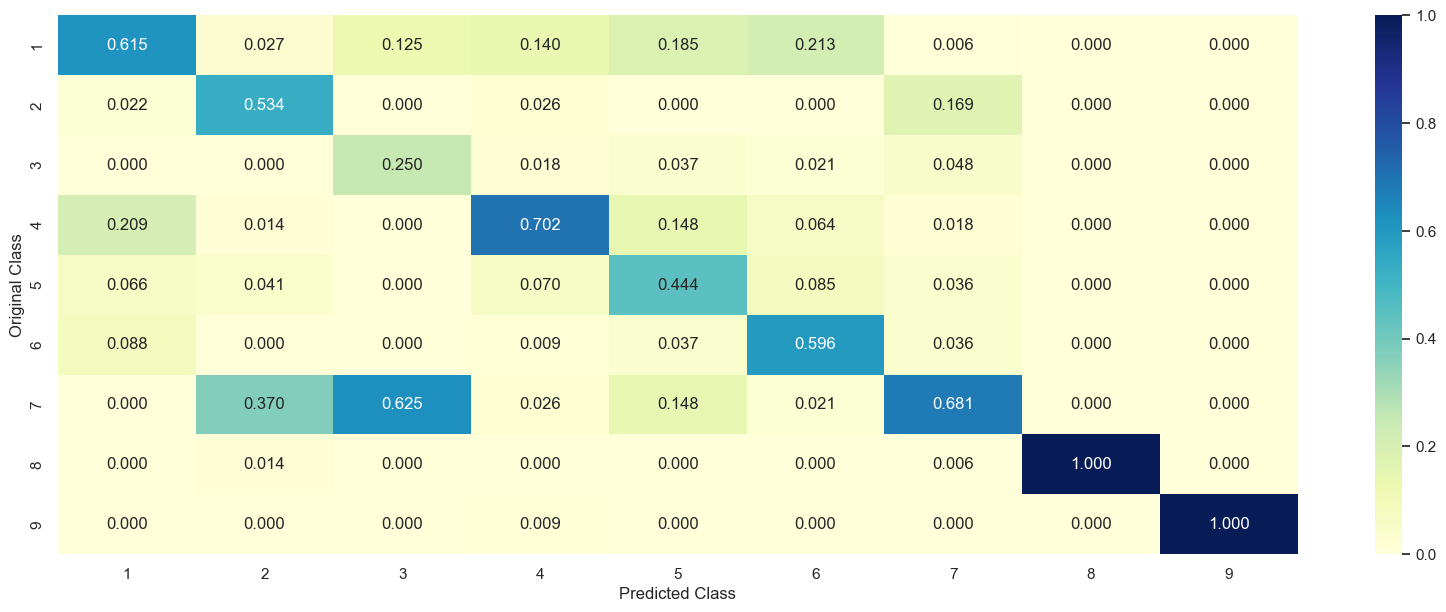

-------------------- Recall matrix (Row sum=1) --------------------


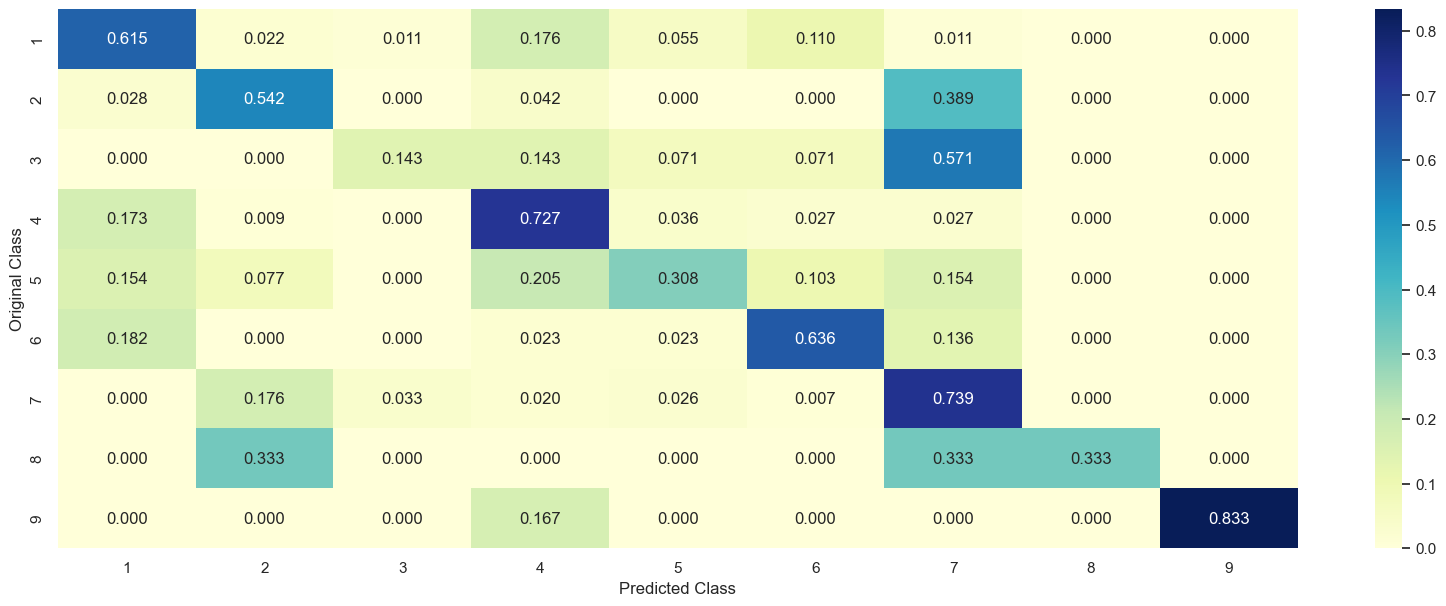

In [311]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, val_x_responseCoding, val_y, clf)

In [312]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 7
The  21  nearest neighbours of the test points belongs to classes [2 2 2 2 7 2 2 2 2 2 2 7 2 2 2 7 7 6 2 2 2]
Fequency of nearest points : Counter({2: 16, 7: 4, 6: 1})


In [313]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 5
The  21  nearest neighbours of the test points belongs to classes [1 1 1 1 1 1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 9]
Fequency of nearest points : Counter({1: 19, 6: 1, 9: 1})


## Logistic Regression

In [314]:
# Balancing all classes
alpha = [10**x for x in range(-6,3)]
cv_log_error_array=[]
for i in alpha:
    print("for alpha=",i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
    cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(val_y, sig_clf_probs))

for alpha= 1e-06
The log loss is: 1.2816569934569948
for alpha= 1e-05
The log loss is: 1.2555305427919696
for alpha= 0.0001
The log loss is: 1.0549792332215306
for alpha= 0.001
The log loss is: 1.037214699868648
for alpha= 0.01
The log loss is: 1.1143911193509852
for alpha= 0.1
The log loss is: 1.4202024853266453
for alpha= 1
The log loss is: 1.6502865122642145
for alpha= 10
The log loss is: 1.6818928957350028
for alpha= 100
The log loss is: 1.685266574038665


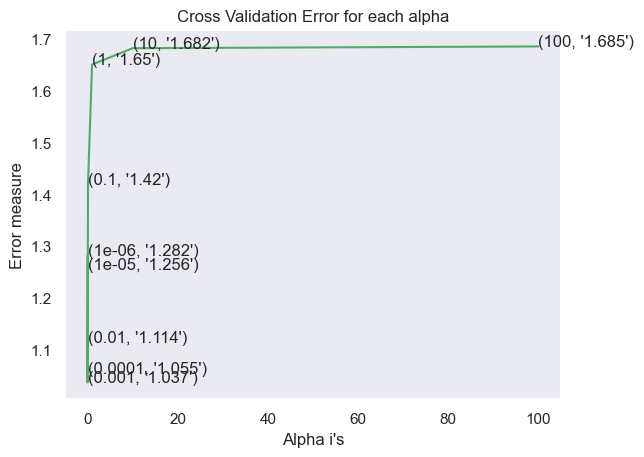

In [315]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [316]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5273292733405158
For values of best alpha =  0.001 The cross validation log loss is: 1.037214699868648
For values of best alpha =  0.001 The test log loss is: 1.133565176765171


Log loss : 1.037214699868648
Number of mis-classified points : 0.3383458646616541
-------------------- Confusion matrix --------------------


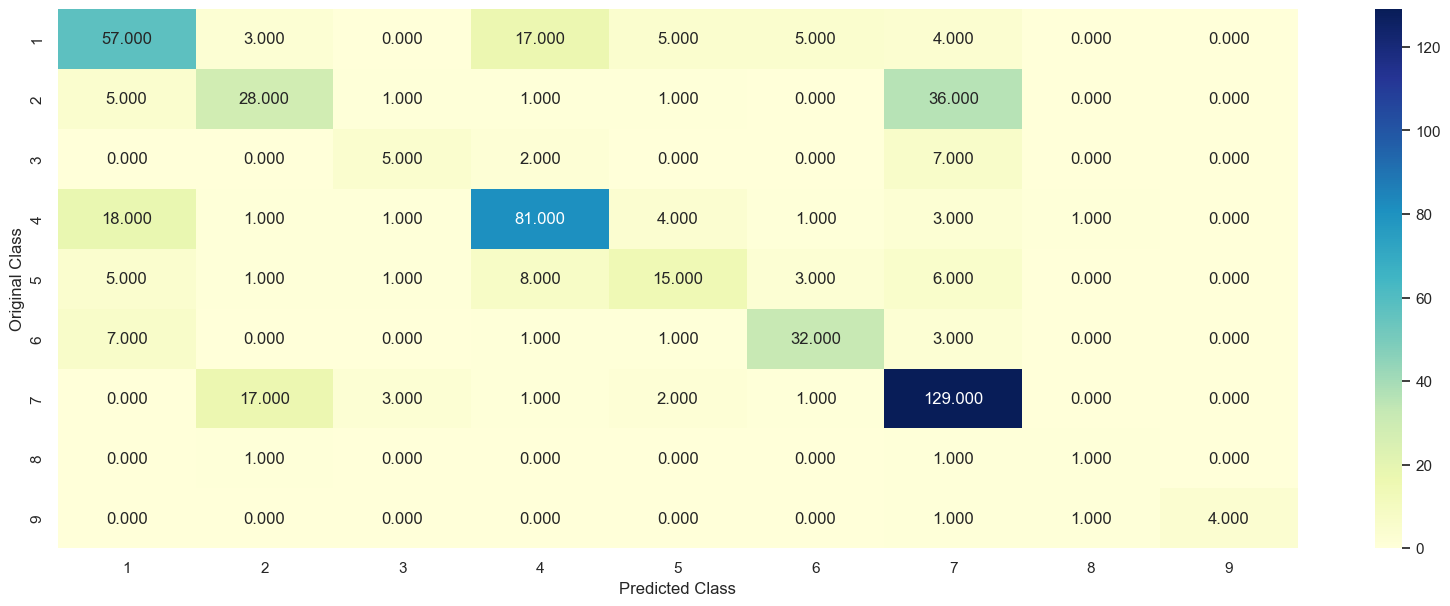

-------------------- Precision matrix (Columm Sum=1) --------------------


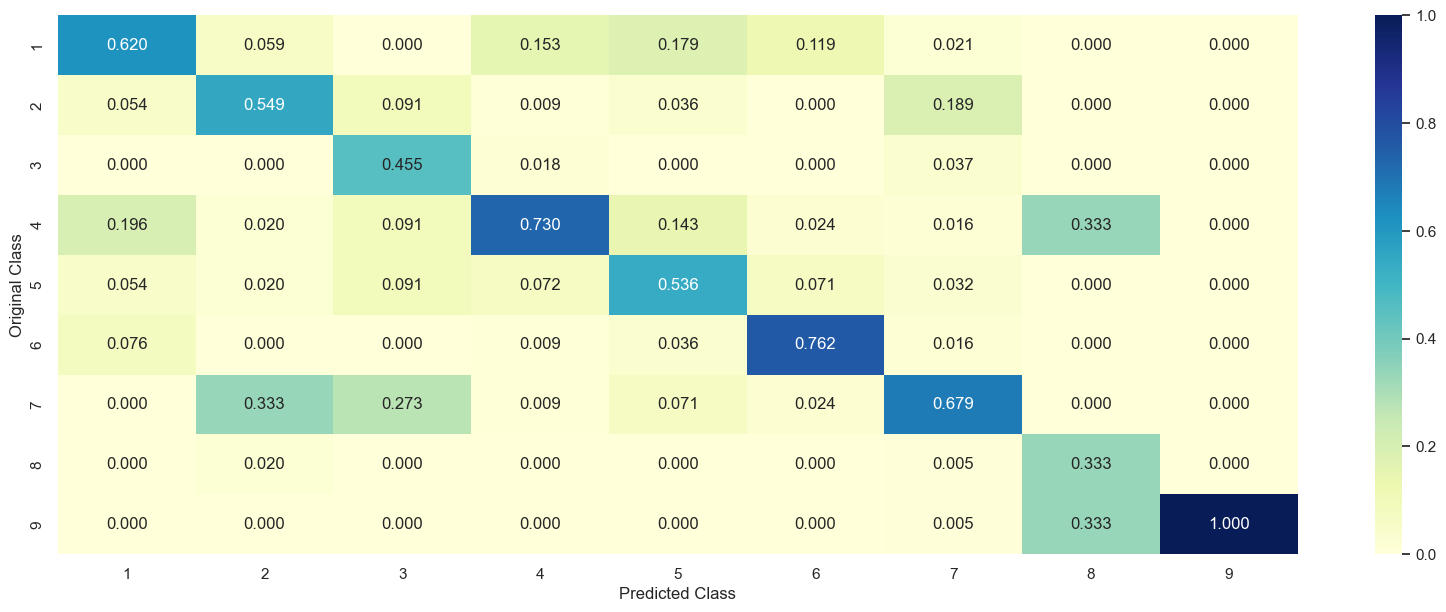

-------------------- Recall matrix (Row sum=1) --------------------


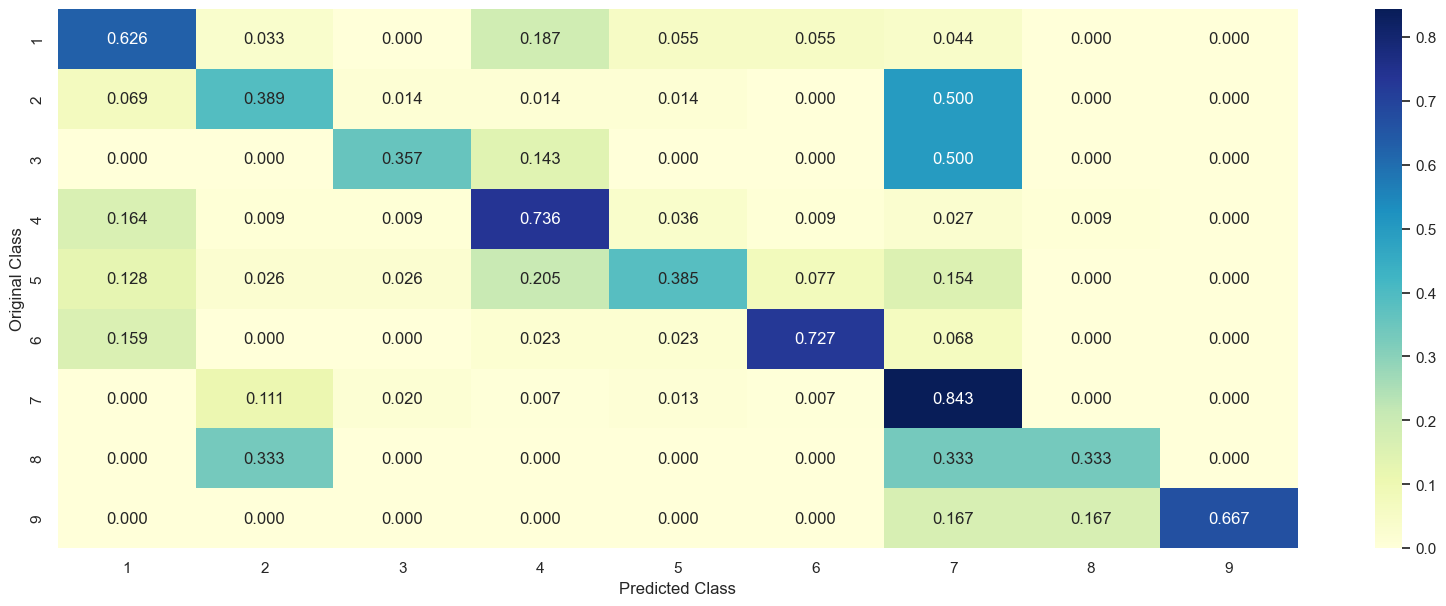

In [317]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, val_x_onehotCoding, val_y, clf)

In [318]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most important features are present in our query point")
    print("-"*50)
    print("The features that are most important of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

In [319]:
# from tabulate import tabulate
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1919 0.2755 0.0155 0.0771 0.0466 0.0329 0.339  0.0135 0.008 ]]
Actual Class : 7
--------------------------------------------------
253 Text feature [frequency] present in test data point [True]
301 Text feature [15th] present in test data point [True]
364 Text feature [powerful] present in test data point [True]
388 Text feature [control] present in test data point [True]
Out of the top  500  features  4 are present in query point


In [320]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.935  0.018  0.0027 0.0113 0.0121 0.0042 0.0084 0.0054 0.0028]]
Actual Class : 5
--------------------------------------------------
144 Text feature [briefly] present in test data point [True]
175 Text feature [application] present in test data point [True]
273 Text feature [transfected] present in test data point [True]
360 Text feature [assessment] present in test data point [True]
378 Text feature [renilla] present in test data point [True]
Out of the top  500  features  5 are present in query point


Repeating without class balancing

In [321]:
alpha = [10**x for x in range(-6,1)]
cv_log_error_array=[]
for i in alpha:
    print("for alpha=",i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
    cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(val_y, sig_clf_probs))

for alpha= 1e-06
The log loss is: 1.2717891705805149
for alpha= 1e-05
The log loss is: 1.2168452908351968
for alpha= 0.0001
The log loss is: 1.053651614295706
for alpha= 0.001
The log loss is: 1.0454070088858176
for alpha= 0.01
The log loss is: 1.1013048089798299
for alpha= 0.1
The log loss is: 1.331170061698409
for alpha= 1
The log loss is: 1.599228337142444


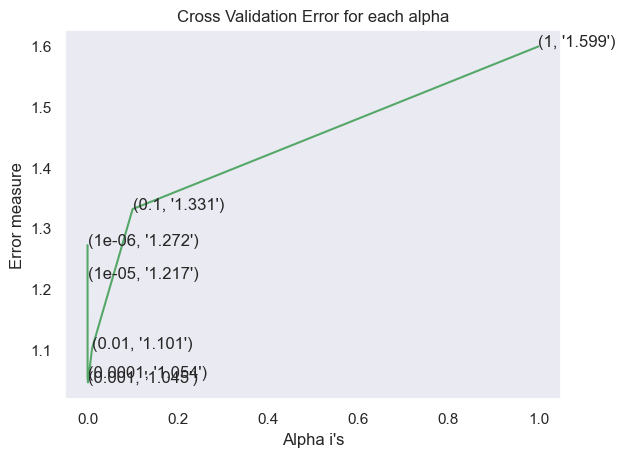

In [322]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [323]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.001 The train log loss is: 0.5260879124742801
For values of best alpha =  0.001 The cross validation log loss is: 1.0454070088858176
For values of best alpha =  0.001 The test log loss is: 1.1474362582842832


Log loss : 1.0454070088858176
Number of mis-classified points : 0.34210526315789475
-------------------- Confusion matrix --------------------


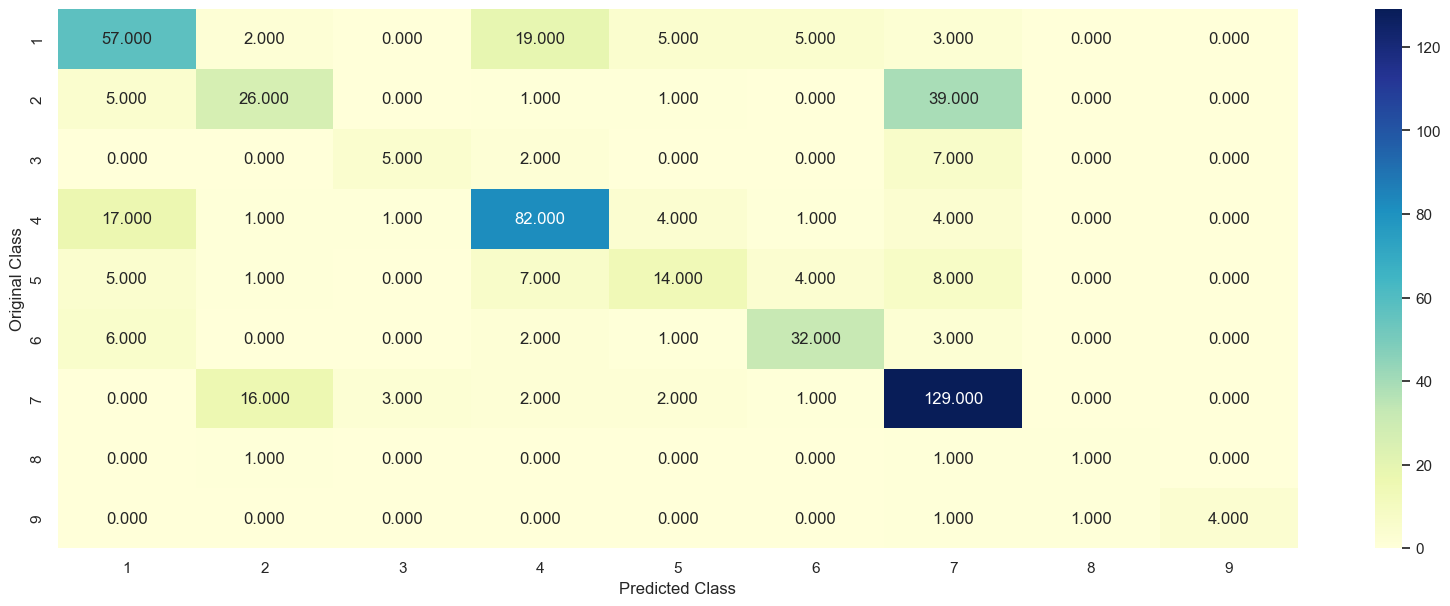

-------------------- Precision matrix (Columm Sum=1) --------------------


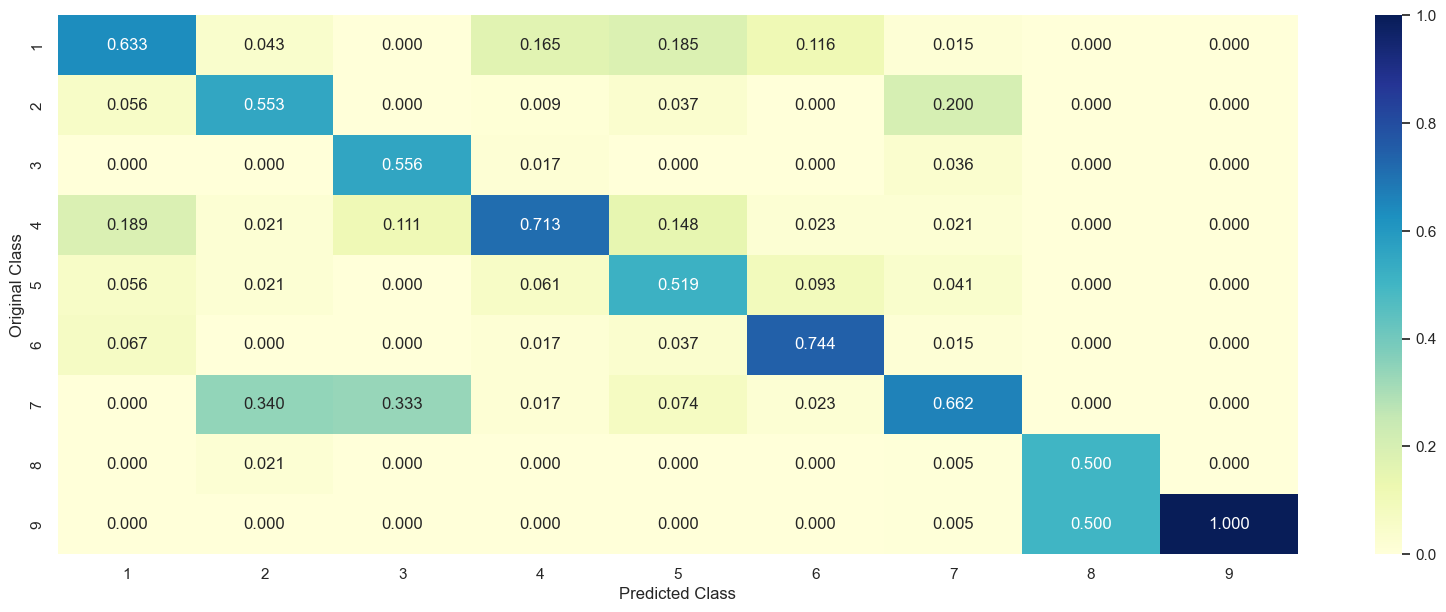

-------------------- Recall matrix (Row sum=1) --------------------


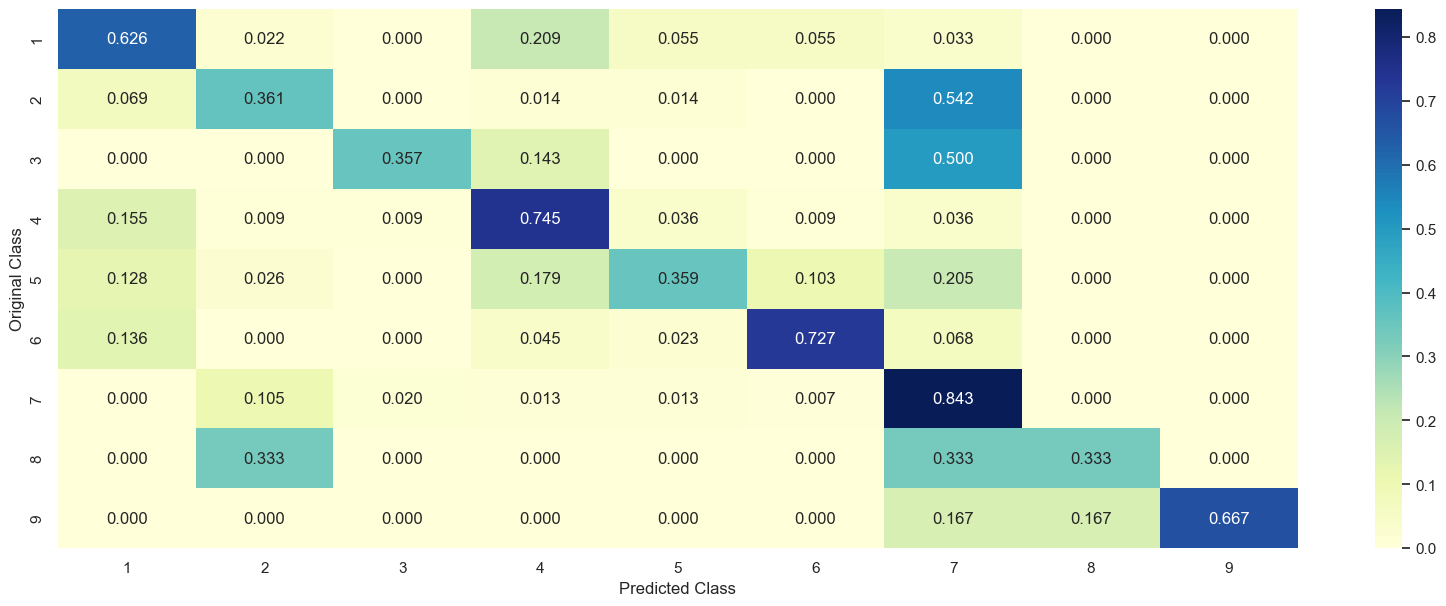

In [324]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, val_x_onehotCoding, val_y, clf)

In [325]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1903 0.2803 0.0177 0.0785 0.0494 0.0353 0.3261 0.0142 0.0083]]
Actual Class : 7
--------------------------------------------------
285 Text feature [frequency] present in test data point [True]
423 Text feature [powerful] present in test data point [True]
439 Text feature [yy1] present in test data point [True]
Out of the top  500  features  3 are present in query point


In [326]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.9342 0.0186 0.0023 0.0123 0.0117 0.0042 0.0103 0.0051 0.0012]]
Actual Class : 5
--------------------------------------------------
152 Text feature [briefly] present in test data point [True]
182 Text feature [application] present in test data point [True]
317 Text feature [transfected] present in test data point [True]
357 Text feature [assessment] present in test data point [True]
419 Text feature [renilla] present in test data point [True]
Out of the top  500  features  5 are present in query point


## Linear Support Vector Machine

In [327]:
alpha = [10**x for x in range(-5,3)]
cv_log_error_array=[]
for i in alpha:
    print("for C =",i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
    cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("The log loss is:",log_loss(val_y, sig_clf_probs))

for C = 1e-05
The log loss is: 1.2520570200713312
for C = 0.0001
The log loss is: 1.1941289754346265
for C = 0.001
The log loss is: 1.1128533178330398
for C = 0.01
The log loss is: 1.101254325948149
for C = 0.1
The log loss is: 1.3274207641532445
for C = 1
The log loss is: 1.6727569395616029
for C = 10
The log loss is: 1.68580097237394
for C = 100
The log loss is: 1.685800731895478


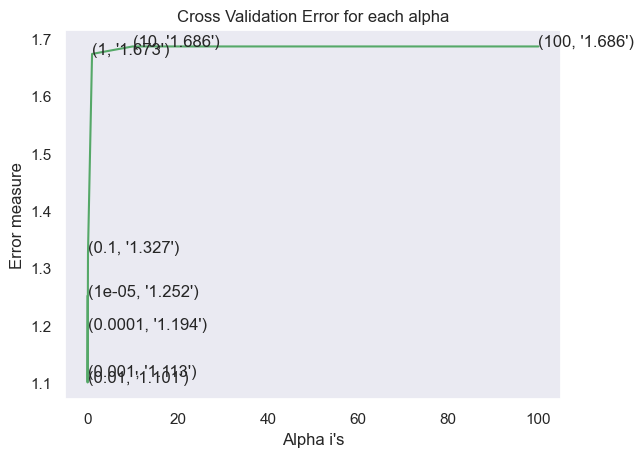

In [328]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

In [329]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight = 'balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.01 The train log loss is: 0.734345762807662
For values of best alpha =  0.01 The cross validation log loss is: 1.101254325948149
For values of best alpha =  0.01 The test log loss is: 1.1691340620700919


Log loss : 1.0986990400591103
Number of mis-classified points : 0.34398496240601506
-------------------- Confusion matrix --------------------


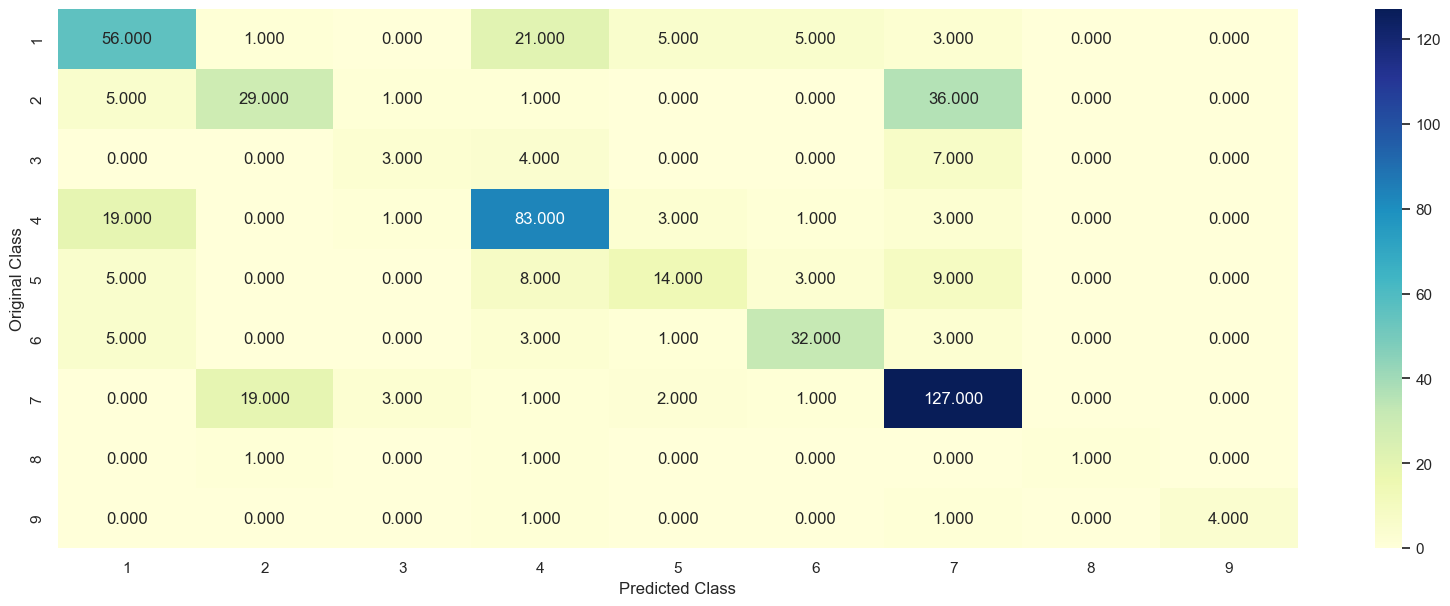

-------------------- Precision matrix (Columm Sum=1) --------------------


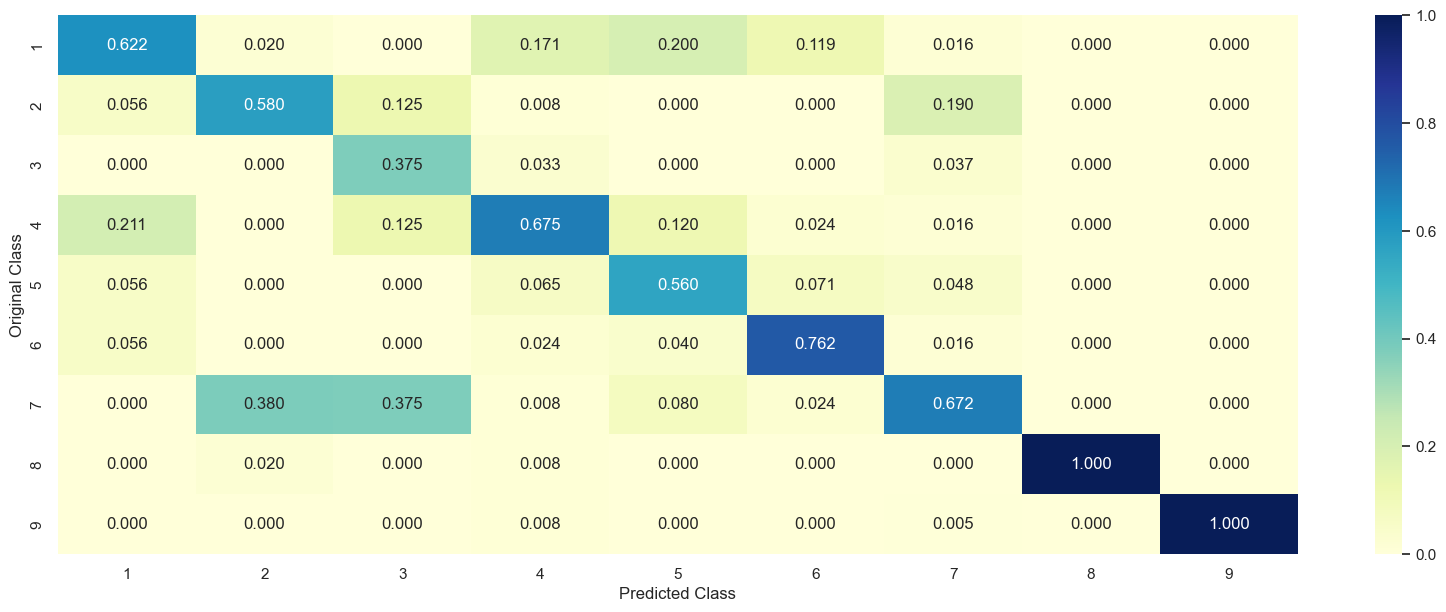

-------------------- Recall matrix (Row sum=1) --------------------


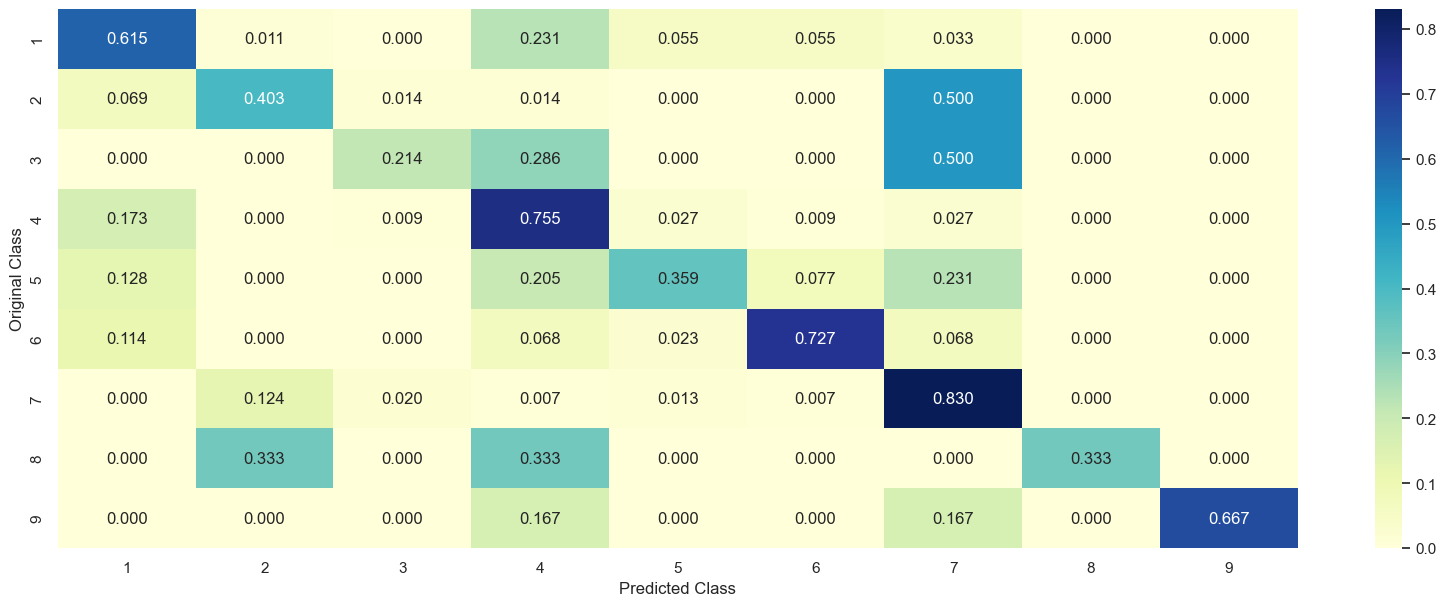

In [330]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, val_x_onehotCoding, val_y, clf)

In [331]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1953 0.2623 0.0168 0.0879 0.052  0.0384 0.33   0.0125 0.0049]]
Actual Class : 7
--------------------------------------------------
287 Text feature [frequency] present in test data point [True]
313 Text feature [surgical] present in test data point [True]
348 Text feature [according] present in test data point [True]
366 Text feature [nonrandom] present in test data point [True]
498 Text feature [table] present in test data point [True]
Out of the top  500  features  5 are present in query point


In [332]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.8022 0.0372 0.009  0.0444 0.0315 0.0163 0.052  0.0048 0.0026]]
Actual Class : 5
--------------------------------------------------
42 Text feature [application] present in test data point [True]
128 Text feature [transfected] present in test data point [True]
250 Text feature [briefly] present in test data point [True]
285 Text feature [renilla] present in test data point [True]
333 Text feature [discovered] present in test data point [True]
362 Text feature [therefore] present in test data point [True]
Out of the top  500  features  6 are present in query point


In [333]:
test_point_index = 50
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0993 0.1735 0.0195 0.1012 0.0737 0.0467 0.4709 0.0093 0.0058]]
Actual Class : 2
--------------------------------------------------
66 Text feature [displacement] present in test data point [True]
191 Text feature [v559d] present in test data point [True]
194 Text feature [celltiter] present in test data point [True]
358 Text feature [grown] present in test data point [True]
498 Text feature [table] present in test data point [True]
Out of the top  500  features  5 are present in query point


## RF with Response Encoding

In [334]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(val_x_responseCoding)
        cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(val_y, sig_clf_probs)) 

for n_estimators = 10 and max depth =  2
Log Loss : 2.1549339599016104
for n_estimators = 10 and max depth =  3
Log Loss : 1.7394102186060925
for n_estimators = 10 and max depth =  5
Log Loss : 1.6358212910613013
for n_estimators = 10 and max depth =  10
Log Loss : 1.69525408030296
for n_estimators = 50 and max depth =  2
Log Loss : 1.6609492429835837
for n_estimators = 50 and max depth =  3
Log Loss : 1.4155278630934462
for n_estimators = 50 and max depth =  5
Log Loss : 1.4185126717267187
for n_estimators = 50 and max depth =  10
Log Loss : 1.7497945481731874
for n_estimators = 100 and max depth =  2
Log Loss : 1.5263573299931967
for n_estimators = 100 and max depth =  3
Log Loss : 1.4652407683553486
for n_estimators = 100 and max depth =  5
Log Loss : 1.3982920797934362
for n_estimators = 100 and max depth =  10
Log Loss : 1.8257832874134807
for n_estimators = 200 and max depth =  2
Log Loss : 1.6395208778559873
for n_estimators = 200 and max depth =  3
Log Loss : 1.4689242917861776

In [337]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  100 The train log loss is: 0.066755956696847
For values of best alpha =  100 The cross validation log loss is: 1.3982920797934362
For values of best alpha =  100 The test log loss is: 1.3696760218480597


Log loss : 1.2061708615268782
Number of mis-classified points : 0.3890977443609023
-------------------- Confusion matrix --------------------


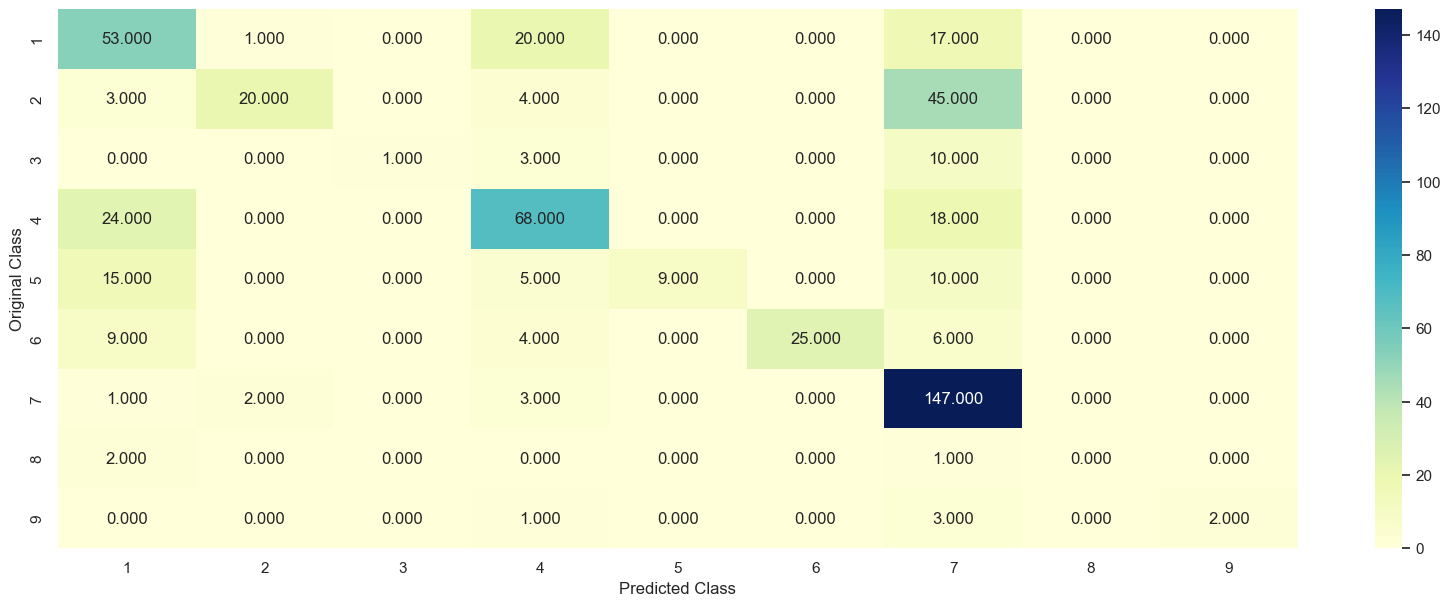

-------------------- Precision matrix (Columm Sum=1) --------------------


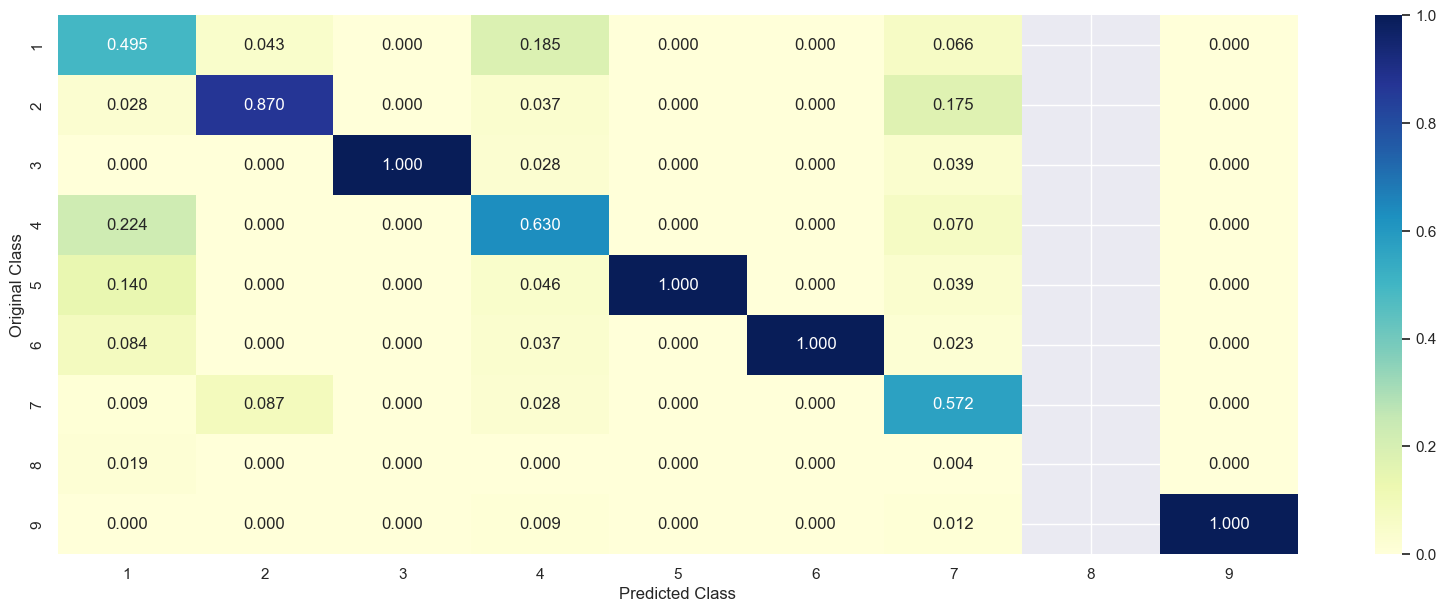

-------------------- Recall matrix (Row sum=1) --------------------


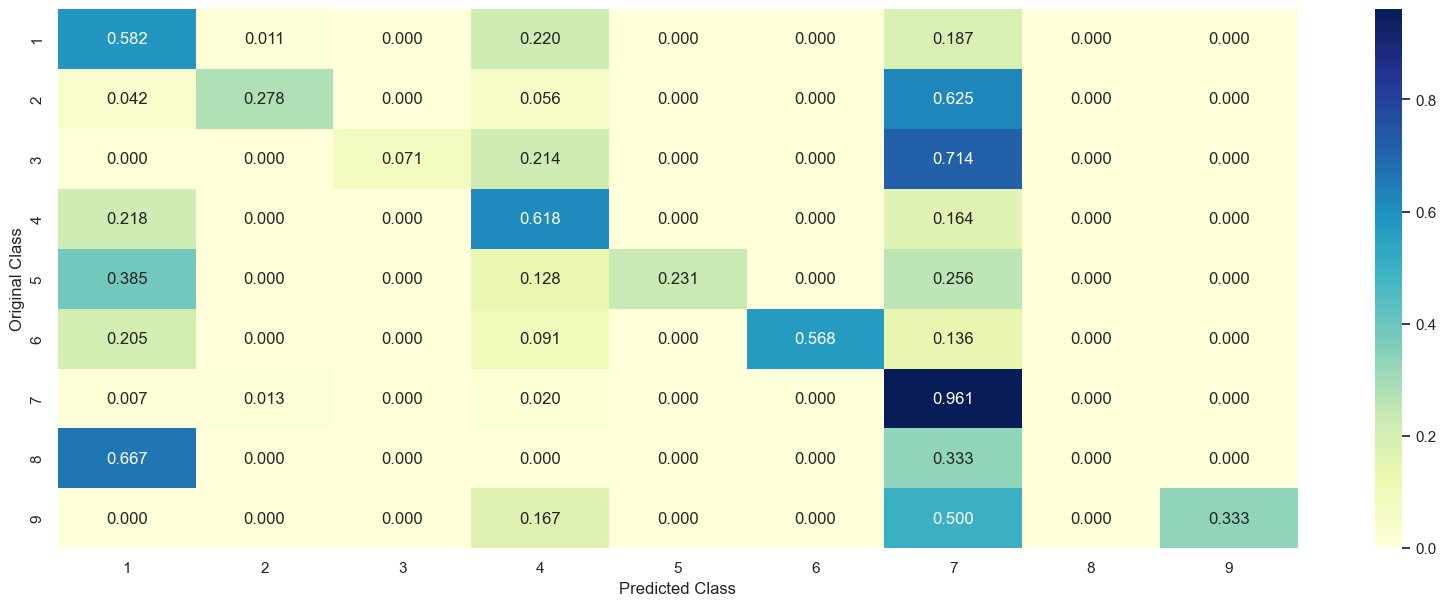

In [339]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, val_x_onehotCoding, val_y, clf)

In [340]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.0218 0.6243 0.0509 0.0328 0.0401 0.0432 0.0836 0.0635 0.0399]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


In [341]:
test_point_index = 100
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 1
Predicted Class Probabilities: [[0.3454 0.0288 0.0845 0.0623 0.061  0.0417 0.0141 0.1696 0.1926]]
Actual Class : 5
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Text is important feature
Text is important feature
Text is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Variation is important feature
Gene is important feature
Text is important feature
Gene is important feature
Variation is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


## Random Forest Classifier

In [342]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(val_x_onehotCoding)
        cv_log_error_array.append(log_loss(val_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(val_y, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.2061708615268782
for n_estimators = 100 and max depth =  10
Log Loss : 1.1387338888963878
for n_estimators = 200 and max depth =  5
Log Loss : 1.1969437487189851
for n_estimators = 200 and max depth =  10
Log Loss : 1.127725367581867
for n_estimators = 500 and max depth =  5
Log Loss : 1.1847670282968559
for n_estimators = 500 and max depth =  10
Log Loss : 1.1173714556438357
for n_estimators = 1000 and max depth =  5
Log Loss : 1.185588812309022
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1144189522127732
for n_estimators = 2000 and max depth =  5
Log Loss : 1.1831070560827017
for n_estimators = 2000 and max depth =  10
Log Loss : 1.1119880572374066


In [343]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(val_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_val, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best estimator =  2000 The train log loss is: 0.6852477936755604
For values of best estimator =  2000 The cross validation log loss is: 1.1119880572374066
For values of best estimator =  2000 The test log loss is: 1.1458789649989773


Log loss : 1.1119880572374066
Number of mis-classified points : 0.38721804511278196
-------------------- Confusion matrix --------------------


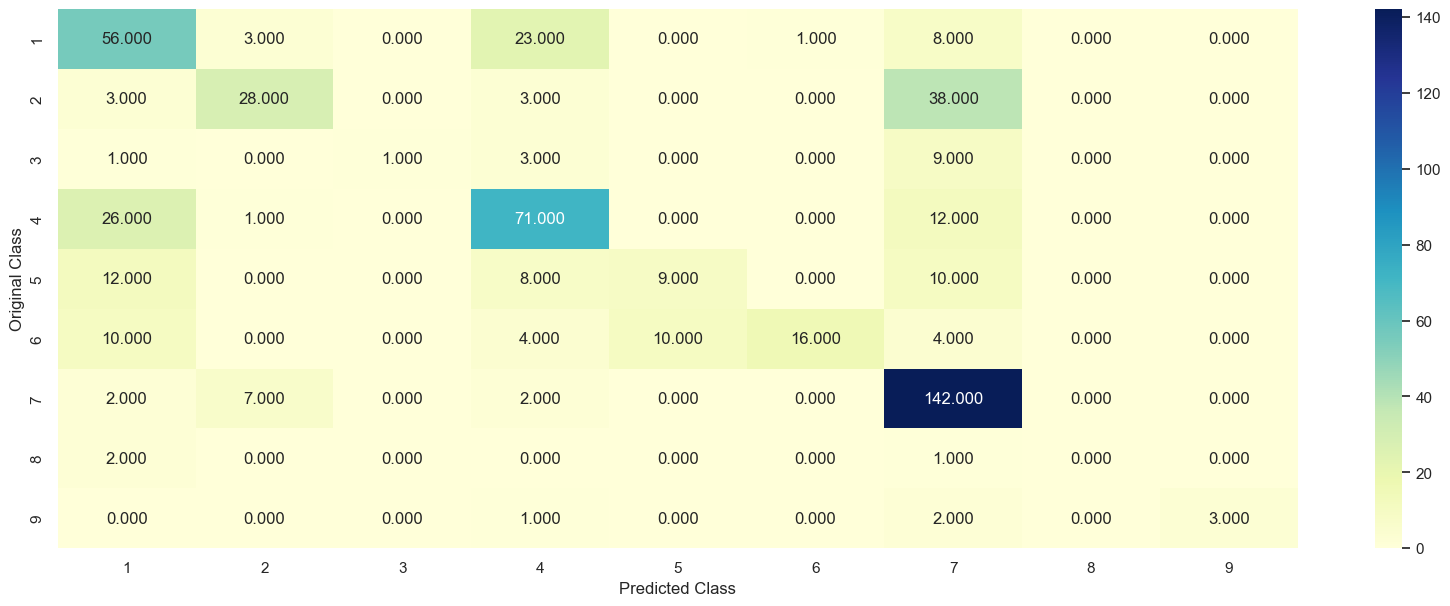

-------------------- Precision matrix (Columm Sum=1) --------------------


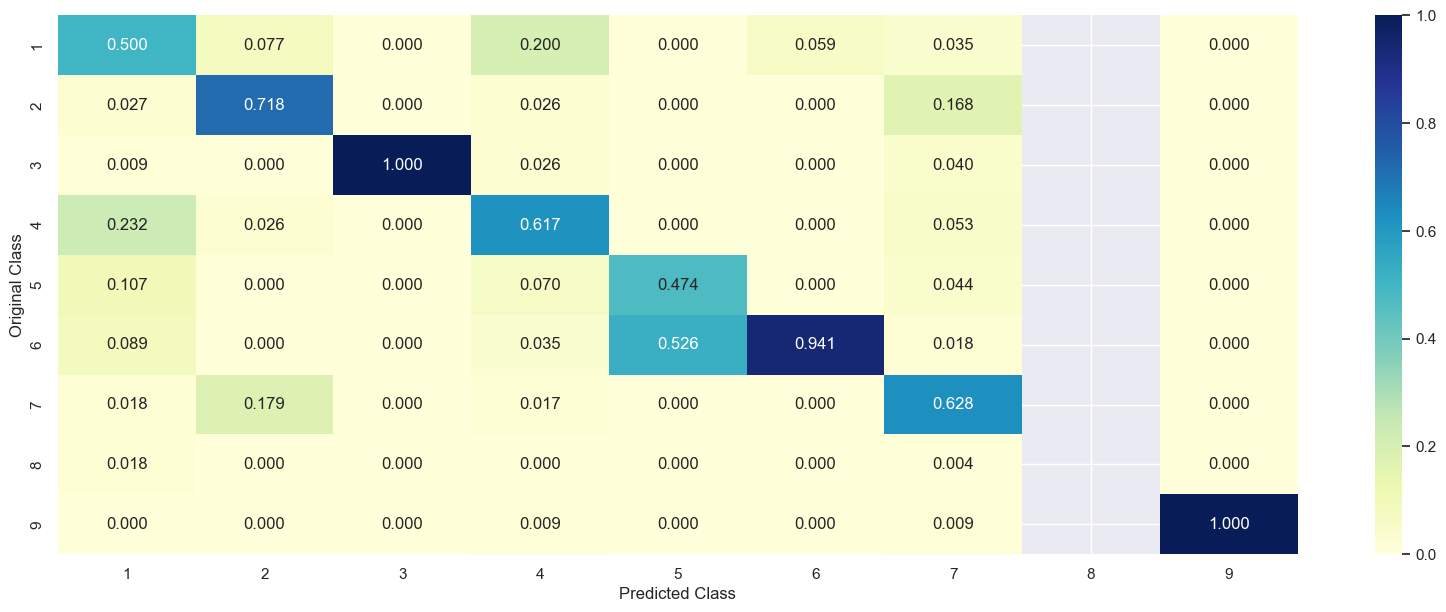

-------------------- Recall matrix (Row sum=1) --------------------


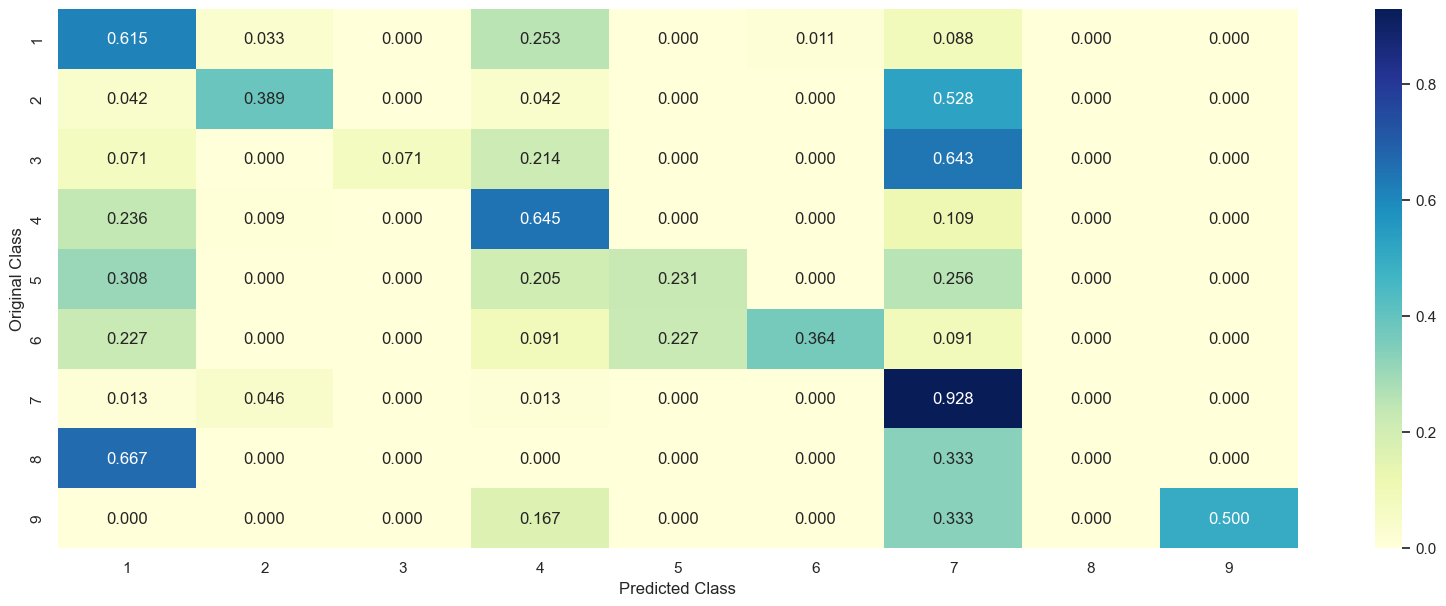

In [345]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, val_x_onehotCoding, val_y, clf)

In [346]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.2468 0.2355 0.025  0.2281 0.066  0.0626 0.1109 0.0132 0.0119]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


## Stacking Classifier

In [347]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(val_y, sig_clf1.predict_proba(val_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(val_y, sig_clf2.predict_proba(val_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(val_y, sig_clf3.predict_proba(val_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(val_y, sclf.predict_proba(val_x_onehotCoding))))
    log_error =log_loss(val_y, sclf.predict_proba(val_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.03
Support vector machines : Log Loss: 1.67
Naive Bayes : Log Loss: 1.24
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.819
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.728
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.336
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.132
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.392
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.749


Log loss (train) on the stacking classifier : 0.500173242137678
Log loss (CV) on the stacking classifier : 1.1323574503880098
Log loss (test) on the stacking classifier : 1.22411975179756
Number of missclassified point : 0.3669172932330827
-------------------- Confusion matrix --------------------


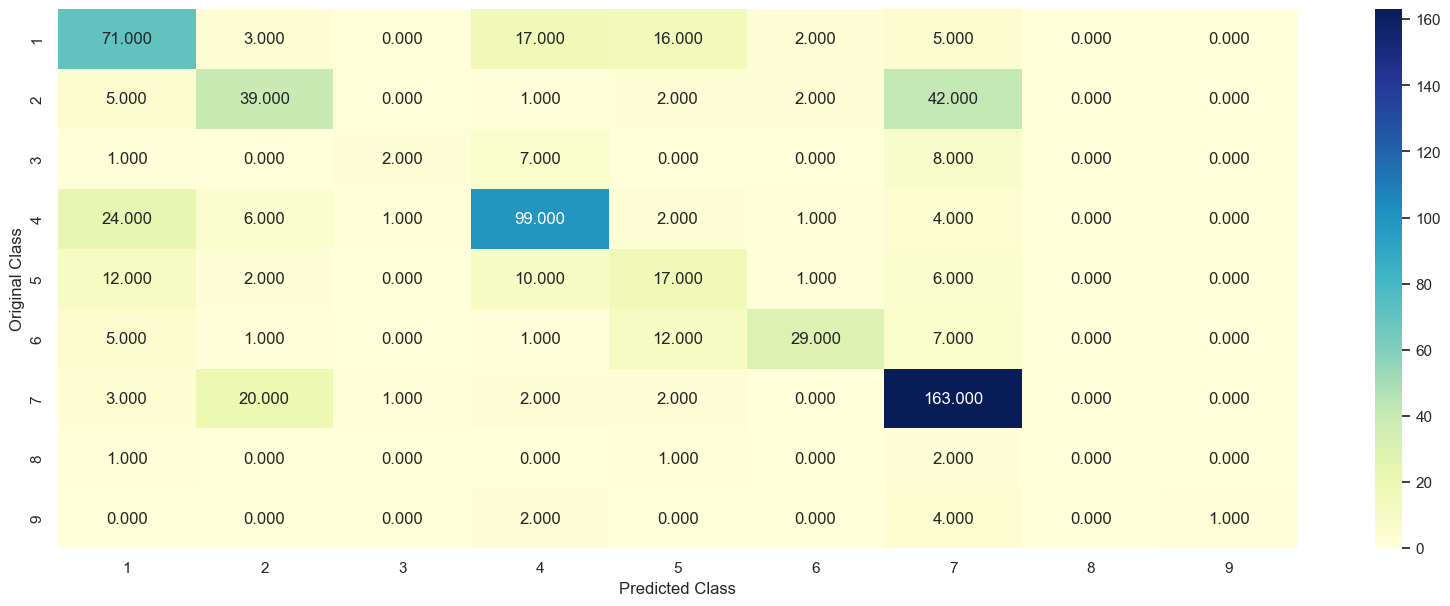

-------------------- Precision matrix (Columm Sum=1) --------------------


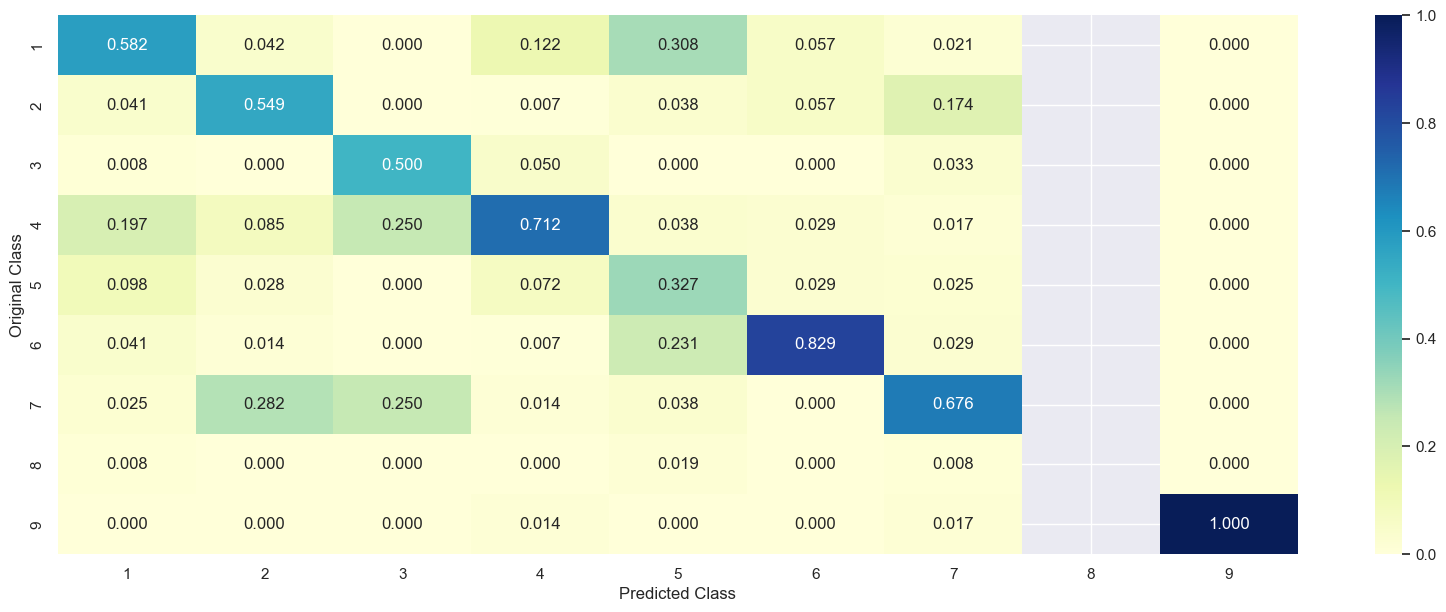

-------------------- Recall matrix (Row sum=1) --------------------


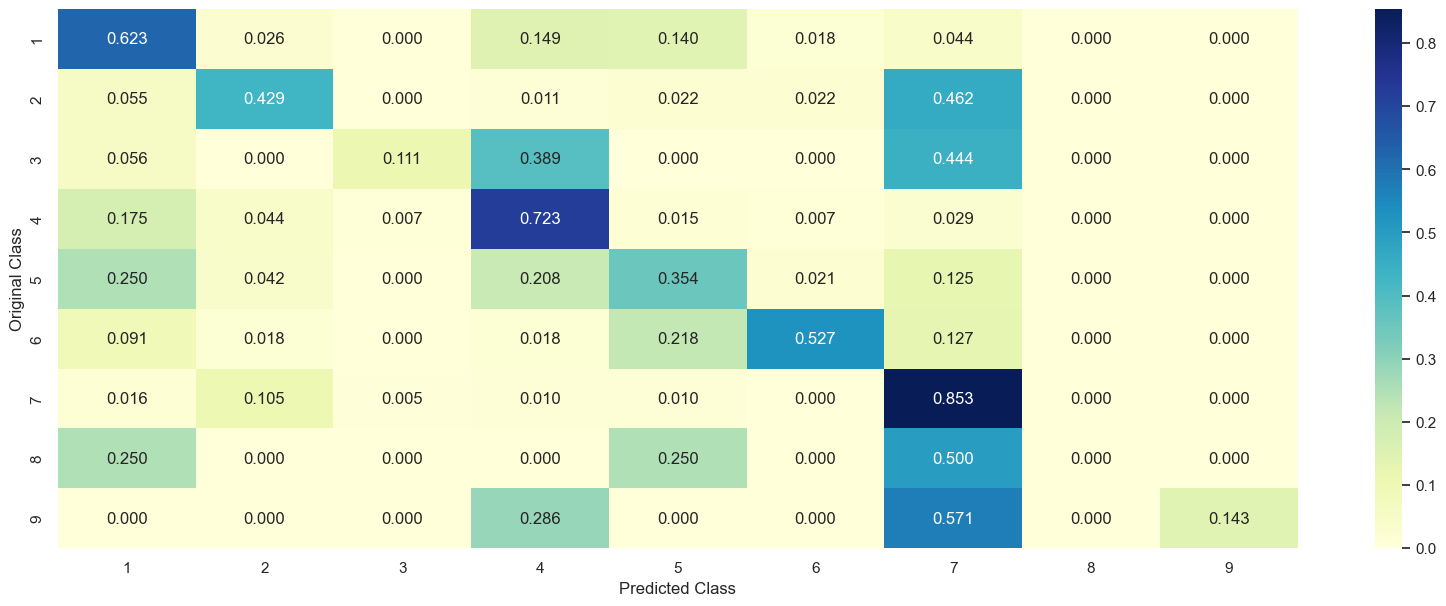

In [348]:
#Testing with the best hyper param
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(val_y, sclf.predict_proba(val_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

## Maximum Voting Classifier

Log loss (train) on the  Voting Classifier : 0.8776129043318299
Log loss (cv) on the  Voting Classifier : 1.1643030431681836
Log loss (test) on the  Voting Classifier : 1.2144435076930922
Number of missclassified point : 0.3744360902255639
-------------------- Confusion matrix --------------------


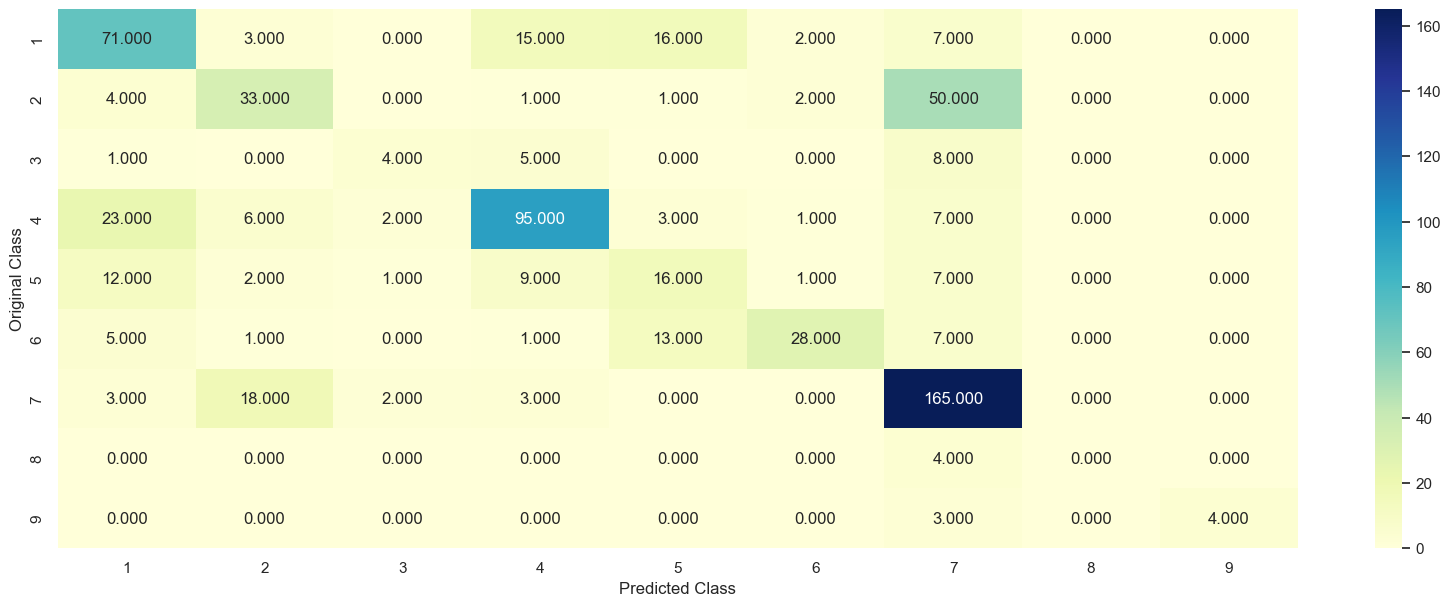

-------------------- Precision matrix (Columm Sum=1) --------------------


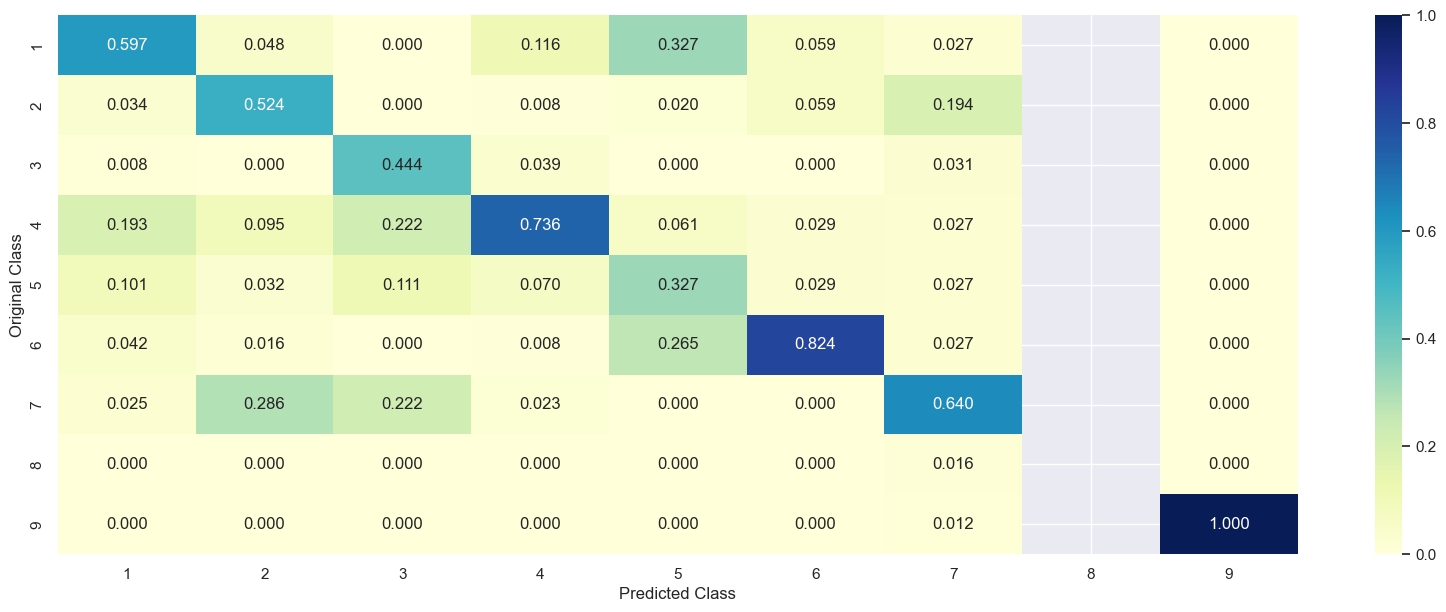

-------------------- Recall matrix (Row sum=1) --------------------


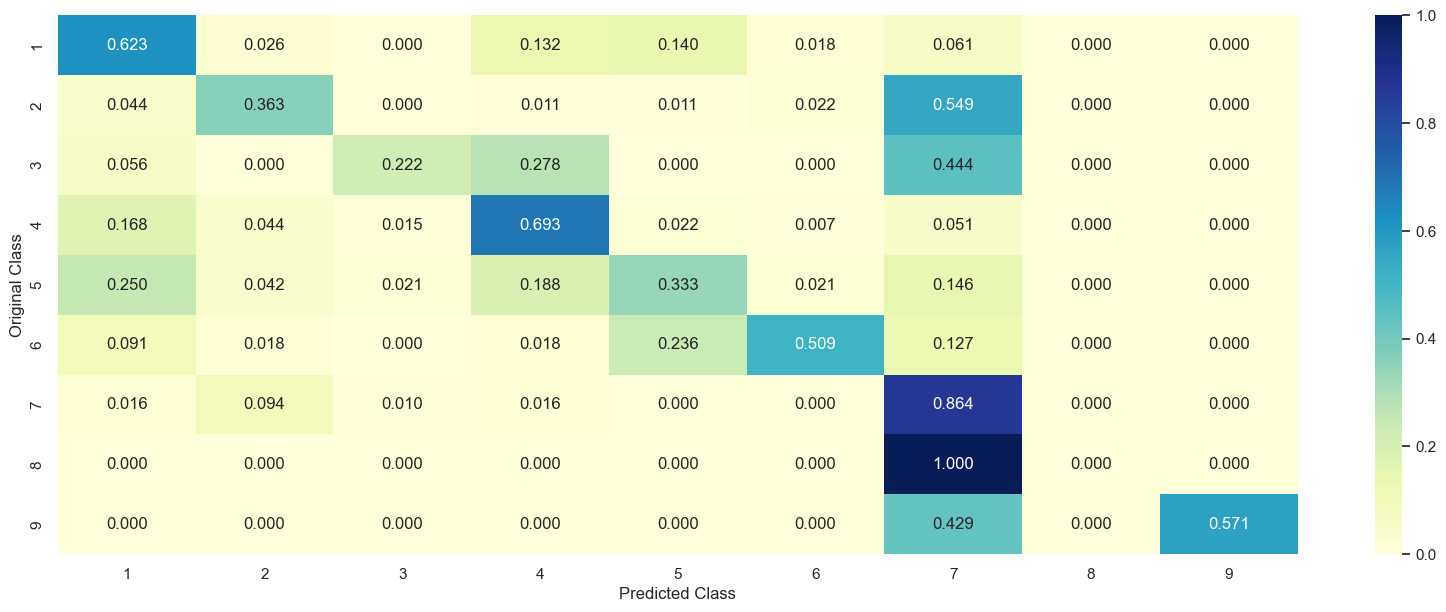

In [349]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators = [('lr', sig_clf1),('svc', sig_clf2),('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the  Voting Classifier :",log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (cv) on the  Voting Classifier :",log_loss(val_y, vclf.predict_proba(val_x_onehotCoding)))
print("Log loss (test) on the  Voting Classifier :",log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))

print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))